# Chat GPT

### ChatGPT V6 - Integrazione Post Grok V2

ESECUZIONE ESEMPIO CON PIÙ DATI...



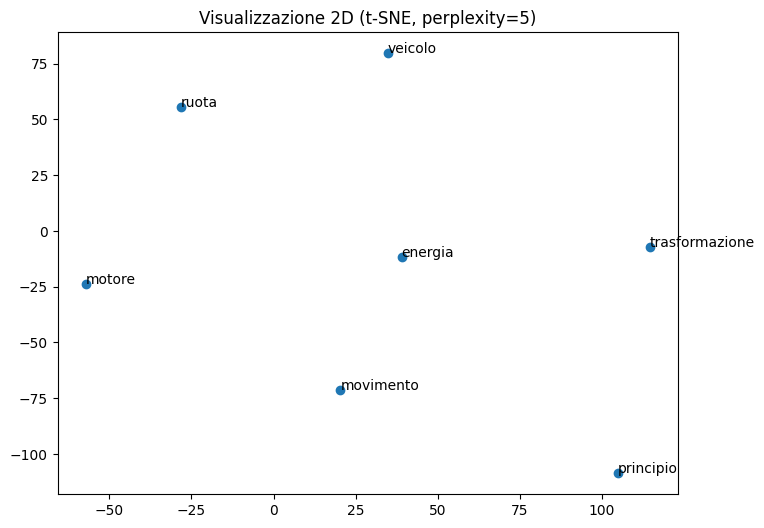


Comunità individuate: [['movimento', 'ruota'], ['motore', 'veicolo'], ['energia', 'trasformazione', 'principio']]

Suggerimenti di Collegamento (similarity > soglia):
('movimento', 'energia', 0.927172064781189)
('energia', 'movimento', 0.927172064781189)
('veicolo', 'energia', 0.9012709856033325)
('energia', 'veicolo', 0.9012709856033325)
('movimento', 'veicolo', 0.8991701006889343)
('veicolo', 'movimento', 0.8991701006889343)
('ruota', 'energia', 0.898320198059082)
('energia', 'ruota', 0.898320198059082)
('motore', 'energia', 0.895886242389679)
('energia', 'motore', 0.895886242389679)
('ruota', 'motore', 0.8913525342941284)
('motore', 'ruota', 0.8913525342941284)
('movimento', 'trasformazione', 0.8797323703765869)
('trasformazione', 'movimento', 0.8797323703765869)
('movimento', 'motore', 0.8788245916366577)
('motore', 'trasformazione', 0.8682631850242615)
('trasformazione', 'motore', 0.8682631850242615)
('movimento', 'principio', 0.8637970089912415)
('principio', 'movimento', 0.8637


Random walk partendo da 'veicolo': ['veicolo', 'motore', 'veicolo', 'motore', 'movimento', 'ruota']

Analisi temporale (ultima mezz'ora): {'nodi_modificati': ['energia', 'trasformazione', 'veicolo', 'movimento', 'ruota', 'motore', 'principio'], 'relazioni_modificate': ['energia -> trasformazione', 'principio -> energia', 'ruota -> veicolo', 'veicolo -> motore', 'movimento -> ruota', 'veicolo -> ruota', 'motore -> veicolo', 'ruota -> movimento', 'motore -> movimento', 'energia -> principio', 'trasformazione -> energia']}

Comunità (livello 2): [['movimento', 'ruota'], ['motore', 'veicolo'], ['trasformazione'], ['energia', 'principio']]


In [ ]:
# =============================================================================
#  FILE: coscienza_conica_enhanced_plus_expanded.py
#  ESEMPIO ESTESO CON PIÙ DATI
# =============================================================================

# Se non hai già installato i pacchetti:
!pip install plotly networkx transformers torch scikit-learn neo4j

import math
import time
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Set
from dataclasses import dataclass
from enum import Enum
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
import json
from pathlib import Path
import warnings
from collections import defaultdict, deque
import heapq

import plotly.graph_objects as go
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch
from neo4j import GraphDatabase

# =============================================================================
# 1) TIPO RELAZIONE E RELAZIONE
# =============================================================================

class TipoRelazione(Enum):
    ISA = "is-a"
    PARTOF = "part-of"
    CAUSA = "causa-effetto"
    CONTRASTO = "contrasto"
    ASSOCIATO = "associato"

    @classmethod
    def get_inverse(cls, tipo: 'TipoRelazione') -> 'TipoRelazione':
        inverse_map = {
            cls.ISA: cls.PARTOF,
            cls.PARTOF: cls.ISA,
            cls.CAUSA: cls.ASSOCIATO,
            cls.CONTRASTO: cls.CONTRASTO,
            cls.ASSOCIATO: cls.ASSOCIATO
        }
        return inverse_map.get(tipo, cls.ASSOCIATO)

@dataclass
class Relazione:
    tipo: TipoRelazione
    peso: float
    note: Optional[str] = None
    timestamp: float = None

    def __post_init__(self):
        if self.tipo == TipoRelazione.CONTRASTO and self.peso > 0:
            self.peso = -abs(self.peso)
        if self.timestamp is None:
            self.timestamp = time.time()

# =============================================================================
# 2) CONFIGURAZIONE E DATACLASS
# =============================================================================

class LivelloCoscienza(Enum):
    BASE = 0
    INTERMEDIO = 1
    ASTRATTO = 2
    ARCHETIPO = 3

    @property
    def peso_livello(self) -> float:
        pesi = {
            self.BASE: 1.0,
            self.INTERMEDIO: 0.8,
            self.ASTRATTO: 0.6,
            self.ARCHETIPO: 0.4
        }
        return pesi[self]

@dataclass
class ConfigurazioneCoscienza:
    dim_embedding: int = 32
    usa_densita_avanzata: bool = True
    max_connessioni_per_nodo: int = 10
    soglia_similarita: float = 0.5
    enable_caching: bool = True
    max_workers: int = 4

    feedback_loop: bool = False
    dynamic_learning_rate: float = 0.05
    use_neo4j: bool = False
    neo4j_uri: str = "bolt://localhost:7687"
    neo4j_user: str = "neo4j"
    neo4j_password: str = "password"

@dataclass
class Proprieta:
    nome: str
    valore: Any
    peso_semantico: float
    timestamp: float = None

    def __post_init__(self):
        if self.timestamp is None:
            self.timestamp = time.time()

    def to_dict(self) -> dict:
        return {
            'nome': self.nome,
            'valore': str(self.valore),
            'peso_semantico': self.peso_semantico,
            'timestamp': self.timestamp
        }

@dataclass
class MetodoApplicazione:
    nome: str
    contesto: str
    prerequisiti: List[str]
    effetti: List[str]
    complessita: Optional[str] = None

    def to_dict(self) -> dict:
        return {
            'nome': self.nome,
            'contesto': self.contesto,
            'prerequisiti': self.prerequisiti,
            'effetti': self.effetti,
            'complessita': self.complessita
        }

# =============================================================================
# 3) CACHE
# =============================================================================

class CacheManager:
    def __init__(self):
        self._cache = {}

    def get(self, key: str) -> Any:
        return self._cache.get(key)

    def set(self, key: str, value: Any):
        self._cache[key] = value

    def clear(self):
        self._cache.clear()

# =============================================================================
# 4) NODO CONCETTUALE
# =============================================================================

class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0,
        config: Optional[ConfigurazioneCoscienza] = None
    ):
        self.oggetto = oggetto
        self.livello = livello
        self.posizione_spirale = posizione_spirale
        self.config = config or ConfigurazioneCoscienza()

        self.r: float = 0.0
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        self.padre: Optional[str] = None
        self.figli: Set[str] = set()

        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []
        self.relazioni: Dict[str, Relazione] = {}

        self.embedding: Optional[np.ndarray] = None

        self._cache = CacheManager() if self.config.enable_caching else None

    def calcola_densita_informativa_avanzata(self) -> float:
        if self._cache:
            cached = self._cache.get('densita')
            if cached is not None:
                return cached

        w_prop = self.livello.peso_livello
        w_met = 0.8 * self.livello.peso_livello
        w_rel = 0.6 * self.livello.peso_livello

        prop_value = 0.0
        for p in self.proprieta:
            delta_t = time.time() - p.timestamp
            prop_value += p.peso_semantico * math.exp(-0.1 * delta_t)

        if len(self.metodi) > 0:
            complessi = sum(1 for m in self.metodi
                            if len(m.prerequisiti) > 2 or len(m.effetti) > 2)
            met_value = len(self.metodi) * math.log2(1 + complessi)
        else:
            met_value = 0.0

        rel_sorted = sorted(self.relazioni.items(),
                            key=lambda x: abs(x[1].peso),
                            reverse=True)

        rel_value = 0.0
        for i, (rel_name, rel_obj) in enumerate(rel_sorted):
            rel_value += rel_obj.peso * math.exp(-0.2 * i)

        densita = w_prop * prop_value + w_met * met_value + w_rel * rel_value

        if self._cache:
            self._cache.set('densita', densita)
        return densita

    def feedback_update(self, feedback_score: float):
        for prop in self.proprieta:
            new_val = prop.peso_semantico + feedback_score * self.config.dynamic_learning_rate
            prop.peso_semantico = max(0.0, new_val)

        for rel in self.relazioni.values():
            new_rel = rel.peso + feedback_score * self.config.dynamic_learning_rate
            rel.peso = max(0.0, new_rel)

    def to_dict(self) -> dict:
        return {
            'oggetto': self.oggetto,
            'livello': self.livello.name,
            'coordinate': {'r': self.r, 'angolo': self.angolo, 'altezza': self.altezza},
            'proprieta': [p.to_dict() for p in self.proprieta],
            'metodi': [m.to_dict() for m in self.metodi],
            'relazioni': {
                dest: {
                    "tipo": rel.tipo.value,
                    "peso": rel.peso,
                    "note": rel.note,
                    "timestamp": rel.timestamp
                }
                for dest, rel in self.relazioni.items()
            },
            'gerarchia': {
                'padre': self.padre,
                'figli': list(self.figli)
            }
        }

# =============================================================================
# 5) SPIRALE DI CONOSCENZA
# =============================================================================

class SpiraleConoscenza:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None

        self._cache = CacheManager() if self.config.enable_caching else None

        self._hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self._hf_model = AutoModel.from_pretrained("bert-base-uncased")

        self._neo4j_driver = None
        if self.config.use_neo4j:
            try:
                self._neo4j_driver = GraphDatabase.driver(
                    self.config.neo4j_uri,
                    auth=(self.config.neo4j_user, self.config.neo4j_password)
                )
            except Exception as e:
                print("Errore di connessione Neo4j:", e)
                self._neo4j_driver = None

    def aggiungi_nodo(self, nodo: NodoConcettuale):
        self.nodi[nodo.oggetto] = nodo
        self.grafo.add_node(nodo.oggetto)

    def collega_nodi(self, origine: str, destinazione: str, peso: float):
        if origine in self.nodi and destinazione in self.nodi:
            from_rel = Relazione(TipoRelazione.ASSOCIATO, peso)
            self.nodi[origine].relazioni[destinazione] = from_rel
            self.grafo.add_edge(origine, destinazione, weight=from_rel.peso)

    def collega_nodi_avanzato(self, origine: str, destinazione: str, relazione: Relazione):
        if origine in self.nodi and destinazione in self.nodi:
            self.nodi[origine].relazioni[destinazione] = relazione
            self.grafo.add_edge(origine, destinazione, weight=relazione.peso)

    def aggiungi_relazione_bidirezionale(self, origine: str, destinazione: str, relazione: Relazione):
        self.collega_nodi_avanzato(origine, destinazione, relazione)
        tipo_inv = TipoRelazione.get_inverse(relazione.tipo)
        rel_inversa = Relazione(tipo_inv, relazione.peso, note=f"Inverso di {relazione.tipo.value}")
        self.collega_nodi_avanzato(destinazione, origine, rel_inversa)

    def collega_padre_figlio(self, padre: str, figlio: str):
        if padre in self.nodi and figlio in self.nodi:
            self.nodi[figlio].padre = padre
            self.nodi[padre].figli.add(figlio)

    def _calcola_similarita(self, nodo1: NodoConcettuale, nodo2: NodoConcettuale) -> float:
        if nodo1.embedding is None or nodo2.embedding is None:
            return 0.0
        dot = float(np.dot(nodo1.embedding, nodo2.embedding))
        norm1 = float(np.linalg.norm(nodo1.embedding))
        norm2 = float(np.linalg.norm(nodo2.embedding))
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return dot / (norm1 * norm2)

    def trova_nodi_simili(self, nodo: NodoConcettuale, k: int = 5) -> List[Tuple[str, float]]:
        similarita = []
        for altro_nodo in self.nodi.values():
            if altro_nodo.oggetto != nodo.oggetto:
                sim = self._calcola_similarita(nodo, altro_nodo)
                similarita.append((altro_nodo.oggetto, sim))
        return heapq.nlargest(k, similarita, key=lambda x: x[1])

    def calcola_percorso_spirale_ottimizzato(self):
        def calcola_posizione(args):
            nodo, idx, total = args
            angolo = (idx / total) * 360
            altezza = nodo.livello.value / LivelloCoscienza.ARCHETIPO.value
            r = 1.0 - (nodo.livello.value / LivelloCoscienza.ARCHETIPO.value)
            return nodo.oggetto, (angolo, r, altezza)

        nodi_ordinati = sorted(
            self.nodi.values(),
            key=lambda n: (n.livello.value, n.calcola_densita_informativa_avanzata())
        )

        with ThreadPoolExecutor(max_workers=self.config.max_workers) as executor:
            posizioni = executor.map(
                calcola_posizione,
                [(n, i, len(nodi_ordinati)) for i, n in enumerate(nodi_ordinati)]
            )

        for oggetto, (angolo, r, altezza) in posizioni:
            nodo = self.nodi[oggetto]
            nodo.angolo = angolo
            nodo.r = r
            nodo.altezza = altezza
            nodo.posizione_spirale = angolo

    def genera_embedding_per_nodo(self, nodo: NodoConcettuale) -> np.ndarray:
        text = nodo.oggetto + " " + " ".join(p.nome for p in nodo.proprieta)
        inputs = self._hf_tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self._hf_model(**inputs)
        emb = outputs.last_hidden_state[0, 0, :].numpy()
        norm = np.linalg.norm(emb)
        if norm > 0:
            emb = emb / norm
        return emb

    def genera_embeddings(self):
        for nodo in self.nodi.values():
            nodo.embedding = self.genera_embedding_per_nodo(nodo)

    def costruisci_matrice_adiacenza(self):
        size = len(self.nodi)
        indice_nodi = {nodo: i for i, nodo in enumerate(self.nodi.keys())}
        mat = np.zeros((size, size))
        for o in self.nodi:
            for d, rel in self.nodi[o].relazioni.items():
                i = indice_nodi[o]
                j = indice_nodi[d]
                mat[i, j] = rel.peso
        self.matrice_adiacenza = mat

    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        visitati = set()
        queue = deque(nodi_modificati)

        while queue:
            nodo_id = queue.popleft()
            if nodo_id in visitati:
                continue
            visitati.add(nodo_id)

            nodo = self.nodi[nodo_id]
            base_emb = self.genera_embedding_per_nodo(nodo)

            vicini = nodo.relazioni.keys()
            vicini_emb = np.zeros_like(base_emb)
            c = 0
            for v in vicini:
                if self.nodi[v].embedding is not None:
                    w = self.nodi[nodo_id].relazioni[v].peso
                    vicini_emb += self.nodi[v].embedding * w
                    c += abs(w)
            if c > 0:
                vicini_emb /= c

            secondi_emb = np.zeros_like(base_emb)
            c2 = 0
            for v in vicini:
                for vv in self.nodi[v].relazioni.keys():
                    if self.nodi[vv].embedding is not None:
                        w2 = self.nodi[v].relazioni[vv].peso
                        secondi_emb += self.nodi[vv].embedding * w2
                        c2 += abs(w2)
            if c2 > 0:
                secondi_emb /= c2

            alpha = 0.7
            beta = 0.2
            gamma = 0.1
            new_emb = alpha*base_emb + beta*vicini_emb + gamma*secondi_emb

            norm = np.linalg.norm(new_emb)
            if norm > 0:
                new_emb = new_emb / norm
            nodo.embedding = new_emb

            if self.config.feedback_loop:
                nodo.feedback_update(0.02)

            for v in vicini:
                if v not in visitati:
                    queue.append(v)

    def visualizza_spirale_3d(self):
        xs, ys, zs, labels = [], [], [], []
        for nodo in self.nodi.values():
            rad = math.radians(nodo.angolo)
            x = nodo.r * math.cos(rad)
            y = nodo.r * math.sin(rad)
            z = nodo.altezza
            xs.append(x)
            ys.append(y)
            zs.append(z)
            labels.append(nodo.oggetto)

        fig = go.Figure(data=[go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode='markers+text',
            text=labels,
            textposition='top center',
            marker=dict(size=4, color='blue')
        )])

        fig.update_layout(scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ), title='Visualizzazione Spirale Conica 3D')

        fig.show()

    def visualizza_embeddings_2d(self):
        all_emb = []
        labels = []
        for nodo in self.nodi.values():
            if nodo.embedding is not None:
                all_emb.append(nodo.embedding)
                labels.append(nodo.oggetto)

        if not all_emb:
            print("Nessun embedding disponibile da visualizzare.")
            return

        all_emb = np.array(all_emb)
        n_samples = len(all_emb)
        perplexity_val = min(5, max(1, n_samples - 1))

        tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42)
        emb_2d = tsne.fit_transform(all_emb)

        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,6))
        plt.scatter(emb_2d[:,0], emb_2d[:,1])
        for i, label in enumerate(labels):
            plt.text(emb_2d[i,0], emb_2d[i,1], label)
        plt.title(f"Visualizzazione 2D (t-SNE, perplexity={perplexity_val})")
        plt.show()

    def random_walk(self, start: str, passi: int = 5) -> List[str]:
        if start not in self.nodi:
            return []
        percorso = [start]
        curr = start
        for _ in range(passi):
            vicini = list(self.nodi[curr].relazioni.keys())
            if not vicini:
                break
            import random
            weights = [abs(self.nodi[curr].relazioni[v].peso) for v in vicini]
            s = sum(weights)
            if s == 0:
                nxt = random.choice(vicini)
            else:
                probs = [w/s for w in weights]
                nxt = random.choices(vicini, weights=probs, k=1)[0]
            percorso.append(nxt)
            curr = nxt
        return percorso

    def trova_communita(self, livello_taglio: int = 1):
        comp = nx.algorithms.community.girvan_newman(self.grafo)
        communities = None
        for i in range(livello_taglio):
            try:
                communities = next(comp)
            except StopIteration:
                break
        if communities is None:
            return []
        else:
            return [list(c) for c in communities]

    def analisi_temporale(self, periodo: float = 3600.0) -> Dict[str, List[str]]:
        now = time.time()
        modifiche_nodi = []
        modifiche_relazioni = []

        for nodo_id, nodo in self.nodi.items():
            for p in nodo.proprieta:
                if now - p.timestamp <= periodo:
                    modifiche_nodi.append(nodo_id)
                    break
            for rel_dest, rel_obj in nodo.relazioni.items():
                if now - rel_obj.timestamp <= periodo:
                    modifiche_relazioni.append(f"{nodo_id} -> {rel_dest}")

        return {
            "nodi_modificati": list(set(modifiche_nodi)),
            "relazioni_modificate": list(set(modifiche_relazioni))
        }

# =============================================================================
# 6) COSCIENZA CONICA
# =============================================================================

class CoscienzaConica:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.spirale = SpiraleConoscenza(self.config)

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(oggetto, livello, config=self.config)
        nodo.proprieta.extend(proprieta)
        nodo.metodi.extend(metodi)
        self.spirale.aggiungi_nodo(nodo)

    def collega_concetti(self, origine: str, destinazione: str, peso: float):
        self.spirale.collega_nodi(origine, destinazione, peso)

    def collega_concetti_avanzato(self, origine: str, destinazione: str, relazione: Relazione):
        self.spirale.collega_nodi_avanzato(origine, destinazione, relazione)

    def collega_relazione_bidirezionale(self, origine: str, destinazione: str, relazione: Relazione):
        self.spirale.aggiungi_relazione_bidirezionale(origine, destinazione, relazione)

    def collega_padre_figlio(self, padre: str, figlio: str):
        self.spirale.collega_padre_figlio(padre, figlio)

    def calcola_struttura(self):
        self.spirale.genera_embeddings()
        self.spirale.calcola_percorso_spirale_ottimizzato()
        self.spirale.costruisci_matrice_adiacenza()

    def analizza_pattern(self) -> Dict[str, Any]:
        return self._analizza()

    def _analizza(self) -> Dict[str, Any]:
        analisi = defaultdict(list)
        for nodo in self.spirale.nodi.values():
            simili = self.spirale.trova_nodi_simili(nodo, k=3)
            if simili:
                analisi['cluster'].append({'centro': nodo.oggetto, 'simili': simili})

        prop_freq = defaultdict(int)
        for nodo in self.spirale.nodi.values():
            for prop in nodo.proprieta:
                prop_freq[prop.nome] += 1
        analisi['proprieta_comuni'] = dict(sorted(
            prop_freq.items(), key=lambda x: x[1], reverse=True
        )[:5])

        try:
            nodi_keys = list(self.spirale.nodi.keys())
            if len(nodi_keys) >= 2:
                percorsi = list(nx.all_shortest_paths(
                    self.spirale.grafo,
                    source=nodi_keys[0],
                    target=nodi_keys[-1]
                ))
            else:
                percorsi = []
            analisi['percorsi_conoscenza'] = percorsi
        except nx.NetworkXNoPath:
            analisi['percorsi_conoscenza'] = []

        return dict(analisi)

    def suggerisci_collegamenti(self) -> List[Tuple[str, str, float]]:
        suggerimenti = []
        for nodo1 in self.spirale.nodi.values():
            for nodo2 in self.spirale.nodi.values():
                if nodo1.oggetto != nodo2.oggetto and nodo2.oggetto not in nodo1.relazioni:
                    sim = self.spirale._calcola_similarita(nodo1, nodo2)
                    if sim > self.config.soglia_similarita:
                        suggerimenti.append((nodo1.oggetto, nodo2.oggetto, sim))
        return sorted(suggerimenti, key=lambda x: x[2], reverse=True)

    def visualizza_3d(self):
        self.spirale.visualizza_spirale_3d()

    def visualizza_embeddings_2d(self):
        self.spirale.visualizza_embeddings_2d()

    def random_walk(self, start: str, passi: int=5) -> List[str]:
        return self.spirale.random_walk(start, passi)

    def trova_communita(self, livello_taglio: int = 1):
        return self.spirale.trova_communita(livello_taglio)

    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        self.spirale.aggiorna_embedding_incr_avanzata(nodi_modificati)

    def analisi_temporale(self, periodo: float = 3600.0) -> Dict[str, List[str]]:
        return self.spirale.analisi_temporale(periodo)

    def integra_feedback(self, nodo_id: str, feedback_score: float):
        if nodo_id in self.spirale.nodi:
            self.spirale.nodi[nodo_id].feedback_update(feedback_score)
            self.aggiorna_embedding_incr_avanzata([nodo_id])

# =============================================================================
# 7) ESEMPIO CON PIÙ DATI
# =============================================================================

def esempio_con_tanti_dati():
    """
    Esempio con più concetti e relazioni
    per una mappa più ricca e una visualizzazione più bella.
    """
    config = ConfigurazioneCoscienza(
        dim_embedding=32,
        usa_densita_avanzata=True,
        max_connessioni_per_nodo=10,
        soglia_similarita=0.5,
        enable_caching=True,
        max_workers=4,
        feedback_loop=False,  # Metti True se vuoi attivare il feedback
        dynamic_learning_rate=0.03,
        use_neo4j=False       # Metti True se hai Neo4j configurato
    )
    coscienza = CoscienzaConica(config)

    # Aggiungiamo vari concetti
    # 1) Ruota (BASE)
    props_ruota = [
        Proprieta("diametro", 0.5, 0.8),
        Proprieta("materiale", "gomma", 0.6),
    ]
    met_ruota = [
        MetodoApplicazione("rotolare", "superficie_piana", ["aderenza"], ["spostamento"])
    ]
    coscienza.aggiungi_concetto("ruota", LivelloCoscienza.BASE, props_ruota, met_ruota)

    # 2) Movimento (INTERMEDIO)
    props_mov = [
        Proprieta("velocita", "variabile", 0.9),
        Proprieta("energia", "cinetica", 0.8)
    ]
    coscienza.aggiungi_concetto("movimento", LivelloCoscienza.INTERMEDIO, props_mov, [])

    # 3) Motore (BASE)
    props_motore = [
        Proprieta("potenza", 100, 0.9),
        Proprieta("combustione", "interna", 0.7)
    ]
    met_motore = [
        MetodoApplicazione("convertire", "carburante", ["aria", "benzina"], ["rotazione"])
    ]
    coscienza.aggiungi_concetto("motore", LivelloCoscienza.BASE, props_motore, met_motore)

    # 4) Veicolo (INTERMEDIO)
    props_veicolo = [
        Proprieta("numero_ruote", 4, 0.7),
        Proprieta("capacita", "trasporto", 0.8)
    ]
    coscienza.aggiungi_concetto("veicolo", LivelloCoscienza.INTERMEDIO, props_veicolo, [])

    # 5) Trasformazione (ASTRATTO)
    props_trasf = [
        Proprieta("cambiamento", "continua_evoluzione", 1.0),
    ]
    coscienza.aggiungi_concetto("trasformazione", LivelloCoscienza.ASTRATTO, props_trasf, [])

    # 6) Energia (ASTRATTO)
    props_energia = [
        Proprieta("forma", "multipla", 0.9),
        Proprieta("legge_di_conservazione", True, 1.0)
    ]
    coscienza.aggiungi_concetto("energia", LivelloCoscienza.ASTRATTO, props_energia, [])

    # 7) Principio (ARCHETIPO)
    props_principio = [
        Proprieta("universale", True, 0.95)
    ]
    coscienza.aggiungi_concetto("principio", LivelloCoscienza.ARCHETIPO, props_principio, [])

    # Colleghiamo i concetti con relazioni
    from enum import Enum

    # ruota PART-OF veicolo
    rel_partof = Relazione(TipoRelazione.PARTOF, 0.8, note="ruota fa parte del veicolo")
    coscienza.collega_relazione_bidirezionale("ruota", "veicolo", rel_partof)

    # motore PART-OF veicolo
    rel_mot_partof = Relazione(TipoRelazione.PARTOF, 0.85, note="motore fa parte del veicolo")
    coscienza.collega_relazione_bidirezionale("motore", "veicolo", rel_mot_partof)

    # movimento CAUSA ruota (girare)
    rel_ca = Relazione(TipoRelazione.CAUSA, 0.7, note="movimento causa rotazione?")
    coscienza.collega_relazione_bidirezionale("movimento", "ruota", rel_ca)

    # movimento associato a motore
    coscienza.collega_concetti("motore", "movimento", 0.6)

    # trasformazione associato a energia
    rel_trasf_ass = Relazione(TipoRelazione.ASSOCIATO, 0.9, note="trasformazione e energia sono collegati")
    coscienza.collega_relazione_bidirezionale("trasformazione", "energia", rel_trasf_ass)

    # energia is-a principio
    rel_energia_princ = Relazione(TipoRelazione.ISA, 0.7, note="energia come un principio base?")
    coscienza.collega_relazione_bidirezionale("energia", "principio", rel_energia_princ)

    # Calcoliamo la struttura (embedding, spirale)
    coscienza.calcola_struttura()

    # Visualizziamo 2D (t-SNE)
    coscienza.visualizza_embeddings_2d()

    # Community detection
    communities = coscienza.trova_communita(livello_taglio=1)
    print("\nComunità individuate:", communities)

    # Suggerimenti di collegamento
    suggerimenti = coscienza.suggerisci_collegamenti()
    print("\nSuggerimenti di Collegamento (similarity > soglia):")
    for sug in suggerimenti:
        print(sug)

    # Aggiornamento incrementale su uno dei nodi, per esempio "veicolo"
    coscienza.aggiorna_embedding_incr_avanzata(["veicolo"])

    # Visualizzazione 3D
    coscienza.visualizza_3d()

    # Esempio random walk
    rw = coscienza.random_walk("veicolo", 5)
    print("\nRandom walk partendo da 'veicolo':", rw)

    # Analisi temporale ultima mezz'ora (1800 secondi)
    temp = coscienza.analisi_temporale(periodo=1800.0)
    print("\nAnalisi temporale (ultima mezz'ora):", temp)

    # Community detection su un secondo livello
    comm2 = coscienza.trova_communita(livello_taglio=2)
    print("\nComunità (livello 2):", comm2)

if __name__ == "__main__":
    print("ESECUZIONE ESEMPIO CON PIÙ DATI...\n")
    esempio_con_tanti_dati()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 3.9 MB/s eta 0:00:00
ESECUZIONE ESEMPIO PLUS...



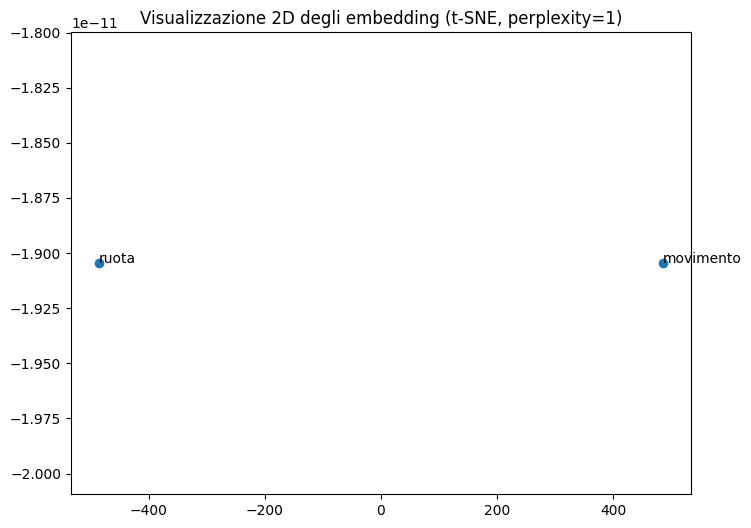

Comunità individuate: [['ruota'], ['movimento']]
Analisi temporale (ultima ora): {'nodi_modificati': ['movimento', 'ruota'], 'relazioni_modificate': ['movimento -> ruota', 'ruota -> movimento']}


In [ ]:
# =============================================================================
#  FILE: coscienza_conica_enhanced_plus_integrata.py
#  DA USARE IN GOOGLE COLAB (singola cella)
# =============================================================================

# Se hai già installato, commenta pure
!pip install plotly networkx transformers torch scikit-learn neo4j

import math
import time
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Set
from dataclasses import dataclass
from enum import Enum
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
import json
from pathlib import Path
import warnings
from collections import defaultdict, deque
import heapq

# Plotly per la visualizzazione 3D
import plotly.graph_objects as go

# Sklearn e TSNE
from sklearn.manifold import TSNE

# Transformers per BERT
from transformers import AutoTokenizer, AutoModel
import torch

# Neo4j per la persistenza opzionale
from neo4j import GraphDatabase


# =============================================================================
# 1) TIPO RELAZIONE E RELAZIONE
# =============================================================================

class TipoRelazione(Enum):
    ISA = "is-a"
    PARTOF = "part-of"
    CAUSA = "causa-effetto"
    CONTRASTO = "contrasto"
    ASSOCIATO = "associato"

    @classmethod
    def get_inverse(cls, tipo: 'TipoRelazione') -> 'TipoRelazione':
        """
        Esempio semplificato di mappa di inversione:
          is-a <--> part-of
          causa-effetto -> associato
          contrasto -> contrasto
          associato -> associato
        """
        inverse_map = {
            cls.ISA: cls.PARTOF,
            cls.PARTOF: cls.ISA,
            cls.CAUSA: cls.ASSOCIATO,
            cls.CONTRASTO: cls.CONTRASTO,
            cls.ASSOCIATO: cls.ASSOCIATO
        }
        return inverse_map.get(tipo, cls.ASSOCIATO)


@dataclass
class Relazione:
    tipo: TipoRelazione
    peso: float  # Può essere anche negativo se "contrasto" è forte
    note: Optional[str] = None
    timestamp: float = None

    def __post_init__(self):
        # Se la relazione è di contrasto ma il peso è positivo, lo forziamo a negativo
        if self.tipo == TipoRelazione.CONTRASTO and self.peso > 0:
            self.peso = -abs(self.peso)
        if self.timestamp is None:
            self.timestamp = time.time()


# =============================================================================
# 2) CONFIGURAZIONE E DATACLASS
# =============================================================================

class LivelloCoscienza(Enum):
    BASE = 0
    INTERMEDIO = 1
    ASTRATTO = 2
    ARCHETIPO = 3

    @property
    def peso_livello(self) -> float:
        """
        Pesi differenti per calcolo densità informativa:
          Base = 1.0, Intermedio = 0.8, Astratto = 0.6, Archetipico = 0.4
        """
        pesi = {
            self.BASE: 1.0,
            self.INTERMEDIO: 0.8,
            self.ASTRATTO: 0.6,
            self.ARCHETIPO: 0.4
        }
        return pesi[self]


@dataclass
class ConfigurazioneCoscienza:
    dim_embedding: int = 128
    usa_densita_avanzata: bool = True
    max_connessioni_per_nodo: int = 10
    soglia_similarita: float = 0.7
    enable_caching: bool = True
    max_workers: int = 4

    # Nuovi parametri
    feedback_loop: bool = False         # Se true, aggiorna i nodi in base al feedback
    dynamic_learning_rate: float = 0.1  # Tasso di aggiustamento
    use_neo4j: bool = False             # Se true, salva/carica su Neo4j
    neo4j_uri: str = "bolt://localhost:7687"
    neo4j_user: str = "neo4j"
    neo4j_password: str = "password"


@dataclass
class Proprieta:
    nome: str
    valore: Any
    peso_semantico: float
    timestamp: float = None

    def __post_init__(self):
        if self.timestamp is None:
            self.timestamp = time.time()

    def to_dict(self) -> dict:
        return {
            'nome': self.nome,
            'valore': str(self.valore),
            'peso_semantico': self.peso_semantico,
            'timestamp': self.timestamp
        }


@dataclass
class MetodoApplicazione:
    nome: str
    contesto: str
    prerequisiti: List[str]
    effetti: List[str]
    complessita: Optional[str] = None

    def to_dict(self) -> dict:
        return {
            'nome': self.nome,
            'contesto': self.contesto,
            'prerequisiti': self.prerequisiti,
            'effetti': self.effetti,
            'complessita': self.complessita
        }


# =============================================================================
# 3) CACHE
# =============================================================================

class CacheManager:
    """Gestisce la cache per i calcoli costosi."""
    def __init__(self):
        self._cache = {}

    def get(self, key: str) -> Any:
        return self._cache.get(key)

    def set(self, key: str, value: Any):
        self._cache[key] = value

    def clear(self):
        self._cache.clear()


# =============================================================================
# 4) NODO CONCETTUALE
# =============================================================================

class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0,
        config: Optional[ConfigurazioneCoscienza] = None
    ):
        self.oggetto = oggetto
        self.livello = livello
        self.posizione_spirale = posizione_spirale
        self.config = config or ConfigurazioneCoscienza()

        # Coordinate coniche
        self.r: float = 0.0
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        # Gerarchia
        self.padre: Optional[str] = None
        self.figli: Set[str] = set()

        # Contenuti
        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []

        # Relazioni
        self.relazioni: Dict[str, Relazione] = {}

        # Embedding
        self.embedding: Optional[np.ndarray] = None

        # Cache
        self._cache = CacheManager() if self.config.enable_caching else None

    def calcola_densita_informativa_avanzata(self) -> float:
        """
        Calcolo della densità informativa con fattore di decadimento sul tempo
        e pesi per relazioni e proprietà.
        """
        if self._cache:
            cached = self._cache.get('densita')
            if cached is not None:
                return cached

        w_prop = self.livello.peso_livello
        w_met = 0.8 * self.livello.peso_livello
        w_rel = 0.6 * self.livello.peso_livello

        # Decay delle proprietà
        prop_value = 0.0
        for p in self.proprieta:
            delta_t = time.time() - p.timestamp
            prop_value += p.peso_semantico * math.exp(-0.1 * delta_t)

        # Metodi
        if len(self.metodi) > 0:
            complessi = sum(1 for m in self.metodi
                            if len(m.prerequisiti) > 2 or len(m.effetti) > 2)
            met_value = len(self.metodi) * math.log2(1 + complessi)
        else:
            met_value = 0.0

        # Relazioni (ordino per intensità)
        rel_sorted = sorted(self.relazioni.items(),
                            key=lambda x: abs(x[1].peso),
                            reverse=True)

        rel_value = 0.0
        for i, (rel_name, rel_obj) in enumerate(rel_sorted):
            rel_value += rel_obj.peso * math.exp(-0.2 * i)

        densita = w_prop * prop_value + w_met * met_value + w_rel * rel_value

        if self._cache:
            self._cache.set('densita', densita)
        return densita

    def feedback_update(self, feedback_score: float):
        """
        Aggiorna le proprietà e le relazioni in base a un punteggio di feedback,
        se la config lo richiede.
        """
        for prop in self.proprieta:
            new_val = prop.peso_semantico + feedback_score * self.config.dynamic_learning_rate
            prop.peso_semantico = max(0.0, new_val)

        for rel in self.relazioni.values():
            new_rel = rel.peso + feedback_score * self.config.dynamic_learning_rate
            rel.peso = max(0.0, new_rel)

    def to_dict(self) -> dict:
        return {
            'oggetto': self.oggetto,
            'livello': self.livello.name,
            'coordinate': {'r': self.r, 'angolo': self.angolo, 'altezza': self.altezza},
            'proprieta': [p.to_dict() for p in self.proprieta],
            'metodi': [m.to_dict() for m in self.metodi],
            'relazioni': {
                dest: {
                    "tipo": rel.tipo.value,
                    "peso": rel.peso,
                    "note": rel.note,
                    "timestamp": rel.timestamp
                }
                for dest, rel in self.relazioni.items()
            },
            'gerarchia': {
                'padre': self.padre,
                'figli': list(self.figli)
            }
        }


# =============================================================================
# 5) SPIRALE DI CONOSCENZA
# =============================================================================

class SpiraleConoscenza:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None

        self._cache = CacheManager() if self.config.enable_caching else None

        # Carichiamo un modello BERT base (o simile)
        self._hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self._hf_model = AutoModel.from_pretrained("bert-base-uncased")

        # Se vogliamo usare Neo4j per la persistenza
        self._neo4j_driver = None
        if self.config.use_neo4j:
            try:
                self._neo4j_driver = GraphDatabase.driver(
                    self.config.neo4j_uri,
                    auth=(self.config.neo4j_user, self.config.neo4j_password)
                )
            except Exception as e:
                print("Errore di connessione Neo4j:", e)
                self._neo4j_driver = None

    def aggiungi_nodo(self, nodo: NodoConcettuale):
        self.nodi[nodo.oggetto] = nodo
        self.grafo.add_node(nodo.oggetto)

    def collega_nodi(self, origine: str, destinazione: str, peso: float):
        if origine in self.nodi and destinazione in self.nodi:
            from_rel = Relazione(TipoRelazione.ASSOCIATO, peso)
            self.nodi[origine].relazioni[destinazione] = from_rel
            self.grafo.add_edge(origine, destinazione, weight=from_rel.peso)

    def collega_nodi_avanzato(self, origine: str, destinazione: str, relazione: Relazione):
        if origine in self.nodi and destinazione in self.nodi:
            self.nodi[origine].relazioni[destinazione] = relazione
            self.grafo.add_edge(origine, destinazione, weight=relazione.peso)

    def aggiungi_relazione_bidirezionale(self, origine: str, destinazione: str, relazione: Relazione):
        # Esempio: 'ruota' PART-OF 'movimento' => 'movimento' ISA 'ruota'
        self.collega_nodi_avanzato(origine, destinazione, relazione)
        tipo_inv = TipoRelazione.get_inverse(relazione.tipo)
        rel_inversa = Relazione(tipo_inv, relazione.peso, note=f"Inverso di {relazione.tipo.value}")
        self.collega_nodi_avanzato(destinazione, origine, rel_inversa)

    def collega_padre_figlio(self, padre: str, figlio: str):
        if padre in self.nodi and figlio in self.nodi:
            self.nodi[figlio].padre = padre
            self.nodi[padre].figli.add(figlio)

    def _calcola_similarita(self, nodo1: NodoConcettuale, nodo2: NodoConcettuale) -> float:
        if nodo1.embedding is None or nodo2.embedding is None:
            return 0.0
        dot = float(np.dot(nodo1.embedding, nodo2.embedding))
        norm1 = float(np.linalg.norm(nodo1.embedding))
        norm2 = float(np.linalg.norm(nodo2.embedding))
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return dot / (norm1 * norm2)

    def trova_nodi_simili(self, nodo: NodoConcettuale, k: int = 5) -> List[Tuple[str, float]]:
        similarita = []
        for altro_nodo in self.nodi.values():
            if altro_nodo.oggetto != nodo.oggetto:
                sim = self._calcola_similarita(nodo, altro_nodo)
                similarita.append((altro_nodo.oggetto, sim))
        return heapq.nlargest(k, similarita, key=lambda x: x[1])

    def calcola_percorso_spirale_ottimizzato(self):
        def calcola_posizione(args):
            nodo, idx, total = args
            angolo = (idx / total) * 360
            altezza = nodo.livello.value / LivelloCoscienza.ARCHETIPO.value
            r = 1.0 - (nodo.livello.value / LivelloCoscienza.ARCHETIPO.value)
            return nodo.oggetto, (angolo, r, altezza)

        nodi_ordinati = sorted(
            self.nodi.values(),
            key=lambda n: (n.livello.value, n.calcola_densita_informativa_avanzata())
        )

        with ThreadPoolExecutor(max_workers=self.config.max_workers) as executor:
            posizioni = executor.map(
                calcola_posizione,
                [(n, i, len(nodi_ordinati)) for i, n in enumerate(nodi_ordinati)]
            )

        for oggetto, (angolo, r, altezza) in posizioni:
            nodo = self.nodi[oggetto]
            nodo.angolo = angolo
            nodo.r = r
            nodo.altezza = altezza
            nodo.posizione_spirale = angolo

    def genera_embedding_per_nodo(self, nodo: NodoConcettuale) -> np.ndarray:
        text = nodo.oggetto + " " + " ".join(p.nome for p in nodo.proprieta)
        inputs = self._hf_tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self._hf_model(**inputs)
        emb = outputs.last_hidden_state[0, 0, :].numpy()
        norm = np.linalg.norm(emb)
        if norm > 0:
            emb = emb / norm
        return emb

    def genera_embeddings(self):
        dim = self.config.dim_embedding
        for nodo in self.nodi.values():
            emb = self.genera_embedding_per_nodo(nodo)
            nodo.embedding = emb

    def costruisci_matrice_adiacenza(self):
        size = len(self.nodi)
        indice_nodi = {nodo: i for i, nodo in enumerate(self.nodi.keys())}
        mat = np.zeros((size, size))
        for o in self.nodi:
            for d, rel in self.nodi[o].relazioni.items():
                i = indice_nodi[o]
                j = indice_nodi[d]
                mat[i, j] = rel.peso
        self.matrice_adiacenza = mat

    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        """
        Esempio di apprendimento incrementale dove ricalcoliamo l'embedding
        e lo aggiorniamo con i vicini di primo e secondo grado.
        """
        visitati = set()
        queue = deque(nodi_modificati)

        while queue:
            nodo_id = queue.popleft()
            if nodo_id in visitati:
                continue
            visitati.add(nodo_id)

            nodo = self.nodi[nodo_id]

            # 1) Embedding di base dal LLM
            base_emb = self.genera_embedding_per_nodo(nodo)

            # 2) Apporto dai vicini (primo grado)
            vicini = nodo.relazioni.keys()
            vicini_emb = np.zeros_like(base_emb)
            c = 0
            for v in vicini:
                if self.nodi[v].embedding is not None:
                    w = self.nodi[nodo_id].relazioni[v].peso
                    vicini_emb += self.nodi[v].embedding * w
                    c += abs(w)
            if c > 0:
                vicini_emb /= c

            # 3) Apporto dai vicini di secondo grado
            secondi_emb = np.zeros_like(base_emb)
            c2 = 0
            for v in vicini:
                for vv in self.nodi[v].relazioni.keys():
                    if self.nodi[vv].embedding is not None:
                        w2 = self.nodi[v].relazioni[vv].peso
                        secondi_emb += self.nodi[vv].embedding * w2
                        c2 += abs(w2)
            if c2 > 0:
                secondi_emb /= c2

            alpha = 0.7
            beta = 0.2
            gamma = 0.1
            new_emb = alpha*base_emb + beta*vicini_emb + gamma*secondi_emb

            norm = np.linalg.norm(new_emb)
            if norm > 0:
                new_emb = new_emb / norm
            nodo.embedding = new_emb

            # Se feedback_loop è attivo, aggiorno anche i pesi (feedback fittizio)
            if self.config.feedback_loop:
                nodo.feedback_update(0.05)

            # Propagazione ai vicini
            for v in vicini:
                if v not in visitati:
                    queue.append(v)

    def salva_su_neo4j(self):
        """
        Se abilitato, salva l'intera struttura su Neo4j
        (cancellando prima i nodi esistenti).
        """
        if not self.config.use_neo4j or not self._neo4j_driver:
            return
        with self._neo4j_driver.session() as session:
            # Cancella tutto
            session.run("MATCH (n) DETACH DELETE n")
            # Crea nodi
            for nodo_id, nodo in self.nodi.items():
                session.run("""
                CREATE (c:Concept {id: $nid, livello: $lvl})
                """, nid=nodo_id, lvl=nodo.livello.name)
            # Crea relazioni
            for nid, nodo in self.nodi.items():
                for rel_dest, rel_obj in nodo.relazioni.items():
                    session.run("""
                    MATCH (a:Concept {id: $start}), (b:Concept {id: $end})
                    CREATE (a)-[r:RELATION {type: $tipo, peso: $peso}]->(b)
                    """, start=nid, end=rel_dest, tipo=rel_obj.tipo.value, peso=rel_obj.peso)

    def visualizza_spirale_3d(self):
        xs, ys, zs, labels = [], [], [], []
        for nodo in self.nodi.values():
            rad = math.radians(nodo.angolo)
            x = nodo.r * math.cos(rad)
            y = nodo.r * math.sin(rad)
            z = nodo.altezza
            xs.append(x)
            ys.append(y)
            zs.append(z)
            labels.append(nodo.oggetto)

        fig = go.Figure(data=[go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode='markers+text',
            text=labels,
            textposition='top center',
            marker=dict(size=4, color='blue')
        )])

        fig.update_layout(scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ), title='Visualizzazione Spirale Conica 3D')

        fig.show()

    def visualizza_embeddings_2d(self):
        all_emb = []
        labels = []
        for nodo in self.nodi.values():
            if nodo.embedding is not None:
                all_emb.append(nodo.embedding)
                labels.append(nodo.oggetto)

        if not all_emb:
            print("Nessun embedding disponibile da visualizzare.")
            return

        all_emb = np.array(all_emb)
        n_samples = len(all_emb)

        # Per evitare errori su poca sample, scegli perplexity sensata
        perplexity_val = min(5, max(1, n_samples - 1))

        tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42)
        emb_2d = tsne.fit_transform(all_emb)

        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,6))
        plt.scatter(emb_2d[:,0], emb_2d[:,1])
        for i, label in enumerate(labels):
            plt.text(emb_2d[i,0], emb_2d[i,1], label)
        plt.title(f"Visualizzazione 2D degli embedding (t-SNE, perplexity={perplexity_val})")
        plt.show()

    def random_walk(self, start: str, passi: int = 5) -> List[str]:
        if start not in self.nodi:
            return []
        percorso = [start]
        curr = start
        for _ in range(passi):
            vicini = list(self.nodi[curr].relazioni.keys())
            if not vicini:
                break
            import random
            weights = [abs(self.nodi[curr].relazioni[v].peso) for v in vicini]
            s = sum(weights)
            if s == 0:
                nxt = random.choice(vicini)
            else:
                probs = [w/s for w in weights]
                nxt = random.choices(vicini, weights=probs, k=1)[0]
            percorso.append(nxt)
            curr = nxt
        return percorso

    def trova_communita(self, livello_taglio: int = 1):
        comp = nx.algorithms.community.girvan_newman(self.grafo)
        communities = None
        for i in range(livello_taglio):
            try:
                communities = next(comp)
            except StopIteration:
                break
        if communities is None:
            return []
        else:
            return [list(c) for c in communities]

    def analisi_temporale(self, periodo: float = 3600.0) -> Dict[str, List[str]]:
        now = time.time()
        modifiche_nodi = []
        modifiche_relazioni = []

        for nodo_id, nodo in self.nodi.items():
            for p in nodo.proprieta:
                if now - p.timestamp <= periodo:
                    modifiche_nodi.append(nodo_id)
                    break
            for rel_dest, rel_obj in nodo.relazioni.items():
                if now - rel_obj.timestamp <= periodo:
                    modifiche_relazioni.append(f"{nodo_id} -> {rel_dest}")

        return {
            "nodi_modificati": list(set(modifiche_nodi)),
            "relazioni_modificate": list(set(modifiche_relazioni))
        }


# =============================================================================
# 6) COSCIENZA CONICA
# =============================================================================

class CoscienzaConica:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.spirale = SpiraleConoscenza(self.config)

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(oggetto, livello, config=self.config)
        nodo.proprieta.extend(proprieta)
        nodo.metodi.extend(metodi)
        self.spirale.aggiungi_nodo(nodo)

        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def collega_concetti(self, origine: str, destinazione: str, peso: float):
        self.spirale.collega_nodi(origine, destinazione, peso)
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def collega_concetti_avanzato(self, origine: str, destinazione: str, relazione: Relazione):
        self.spirale.collega_nodi_avanzato(origine, destinazione, relazione)
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def collega_relazione_bidirezionale(self, origine: str, destinazione: str, relazione: Relazione):
        self.spirale.aggiungi_relazione_bidirezionale(origine, destinazione, relazione)
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def collega_padre_figlio(self, padre: str, figlio: str):
        self.spirale.collega_padre_figlio(padre, figlio)
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def calcola_struttura(self):
        self.spirale.genera_embeddings()
        self.spirale.calcola_percorso_spirale_ottimizzato()
        self.spirale.costruisci_matrice_adiacenza()
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def analizza_pattern(self) -> Dict[str, Any]:
        analisi = defaultdict(list)
        for nodo in self.spirale.nodi.values():
            simili = self.spirale.trova_nodi_simili(nodo, k=3)
            if simili:
                analisi['cluster'].append({'centro': nodo.oggetto, 'simili': simili})

        # Frequenza proprietà
        prop_freq = defaultdict(int)
        for nodo in self.spirale.nodi.values():
            for prop in nodo.proprieta:
                prop_freq[prop.nome] += 1
        analisi['proprieta_comuni'] = dict(sorted(
            prop_freq.items(), key=lambda x: x[1], reverse=True
        )[:5])

        # Percorsi di conoscenza
        try:
            nodi_keys = list(self.spirale.nodi.keys())
            if len(nodi_keys) >= 2:
                percorsi = list(nx.all_shortest_paths(
                    self.spirale.grafo,
                    source=nodi_keys[0],
                    target=nodi_keys[-1]
                ))
            else:
                percorsi = []
            analisi['percorsi_conoscenza'] = percorsi
        except nx.NetworkXNoPath:
            analisi['percorsi_conoscenza'] = []

        return dict(analisi)

    def suggerisci_collegamenti(self) -> List[Tuple[str, str, float]]:
        suggerimenti = []
        for nodo1 in self.spirale.nodi.values():
            for nodo2 in self.spirale.nodi.values():
                if nodo1.oggetto != nodo2.oggetto and nodo2.oggetto not in nodo1.relazioni:
                    sim = self.spirale._calcola_similarita(nodo1, nodo2)
                    if sim > self.config.soglia_similarita:
                        suggerimenti.append((nodo1.oggetto, nodo2.oggetto, sim))
        return sorted(suggerimenti, key=lambda x: x[2], reverse=True)

    # Metodi di servizio
    def visualizza_3d(self):
        self.spirale.visualizza_spirale_3d()

    def visualizza_embeddings_2d(self):
        self.spirale.visualizza_embeddings_2d()

    def random_walk(self, start: str, passi: int=5) -> List[str]:
        return self.spirale.random_walk(start, passi)

    def trova_communita(self, livello_taglio: int = 1):
        return self.spirale.trova_communita(livello_taglio)

    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        self.spirale.aggiorna_embedding_incr_avanzata(nodi_modificati)
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    def analisi_temporale(self, periodo: float = 3600.0) -> Dict[str, List[str]]:
        return self.spirale.analisi_temporale(periodo)

    def integra_feedback(self, nodo_id: str, feedback_score: float):
        """
        Aggiorna un nodo specifico (feedback) e ricalcola embedding incrementali.
        """
        if nodo_id in self.spirale.nodi:
            self.spirale.nodi[nodo_id].feedback_update(feedback_score)
            self.aggiorna_embedding_incr_avanzata([nodo_id])


# =============================================================================
# 7) ESEMPIO
# =============================================================================

def esempio_plus():
    """
    Esempio di utilizzo della coscienza a cono con:
      - Tasso di apprendimento dinamico
      - Feedback loop
      - Salvataggio Neo4j (se configurato)
      - BERT embedding
      - Visualizzazione 2D/3D
    """
    config = ConfigurazioneCoscienza(
        dim_embedding=32,   # Usa dimensione ridotta se non vuoi caricare troppo la CPU/GPU
        usa_densita_avanzata=True,
        max_connessioni_per_nodo=10,
        soglia_similarita=0.5,
        enable_caching=True,
        max_workers=4,
        feedback_loop=True,
        dynamic_learning_rate=0.05,
        use_neo4j=False  # Metti True se hai Neo4j attivo e configurato
    )
    coscienza = CoscienzaConica(config)

    # Aggiunta di alcuni concetti
    proprieta_ruota = [
        Proprieta("diametro", 0.5, 0.8),
        Proprieta("materiale", "gomma", 0.6)
    ]
    metodi_ruota = [
        MetodoApplicazione("rotolare", "superficie_piana", ["aderenza"], ["spostamento"])
    ]
    coscienza.aggiungi_concetto("ruota", LivelloCoscienza.BASE, proprieta_ruota, metodi_ruota)

    proprieta_movimento = [
        Proprieta("velocita", "variabile", 0.9)
    ]
    coscienza.aggiungi_concetto("movimento", LivelloCoscienza.INTERMEDIO, proprieta_movimento, [])

    # Creiamo una relazione 'ruota PART-OF movimento'
    rel_partof = Relazione(TipoRelazione.PARTOF, 0.9, note="Ruota fa parte del Movimento")
    coscienza.collega_relazione_bidirezionale("ruota", "movimento", rel_partof)

    # Calcola embeddings e spirale
    coscienza.calcola_struttura()

    # Visualizza 2D
    coscienza.visualizza_embeddings_2d()

    # Community detection
    communities = coscienza.trova_communita(livello_taglio=1)
    print("Comunità individuate:", communities)

    # Aggiornamento incrementale con feedback
    coscienza.integra_feedback("movimento", 0.3)

    # Analisi temporale
    temp = coscienza.analisi_temporale(periodo=3600.0)
    print("Analisi temporale (ultima ora):", temp)

    # Visualizza 3D
    coscienza.visualizza_3d()

if __name__ == "__main__":
    print("ESECUZIONE ESEMPIO PLUS...\n")
    esempio_plus()


### ChatGPT V5

ESECUZIONE ESEMPIO PLUS...



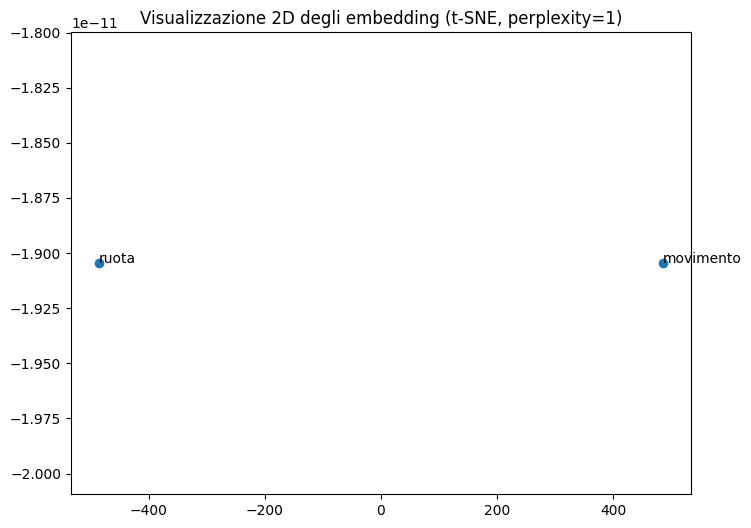

Comunità individuate: [['ruota'], ['movimento']]
Analisi temporale (ultima ora): {'nodi_modificati': ['movimento', 'ruota'], 'relazioni_modificate': ['movimento -> ruota', 'ruota -> movimento']}


In [ ]:
# =============================================================================
#  FILE: coscienza_conica_enhanced_plus.py
#  DA USARE IN GOOGLE COLAB (singola cella)
# =============================================================================

!pip install plotly networkx
# Se vuoi usare LLM e clustering, scommenta:
# !pip install transformers torch scikit-learn

import math
import time
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Set
from dataclasses import dataclass
from enum import Enum
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
import json
from pathlib import Path
import warnings
from collections import defaultdict, deque
import heapq

try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False

# Per embeddings BERT, se disponibili
USE_HF = False
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    USE_HF = True
except ImportError:
    pass

try:
    from sklearn.manifold import TSNE
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False

# =============================================================================
# 1) TIPO RELAZIONE E RELAZIONE
# =============================================================================

class TipoRelazione(Enum):
    ISA = "is-a"
    PARTOF = "part-of"
    CAUSA = "causa-effetto"
    CONTRASTO = "contrasto"
    ASSOCIATO = "associato"

    @classmethod
    def get_inverse(cls, tipo: 'TipoRelazione') -> 'TipoRelazione':
        """
        Esempio semplificato di mappa d'inversione.
        Si può ovviamente personalizzare in base alla semantica desiderata.
        """
        inverse_map = {
            cls.ISA: cls.PARTOF,       # "is-a" <--> "part-of" (esempio)
            cls.PARTOF: cls.ISA,       # inverso
            cls.CAUSA: cls.ASSOCIATO,  # "causa-effetto" -> "associato"? (decidi tu)
            cls.CONTRASTO: cls.CONTRASTO,  # l'inverso di "contrasto" è se stesso
            cls.ASSOCIATO: cls.ASSOCIATO   # "associato" di default è simmetrico
        }
        return inverse_map.get(tipo, cls.ASSOCIATO)

@dataclass
class Relazione:
    tipo: TipoRelazione
    peso: float  # Può essere anche negativo se "contrasto" è forte
    note: Optional[str] = None
    timestamp: float = None

    def __post_init__(self):
        if self.tipo == TipoRelazione.CONTRASTO and self.peso > 0:
            self.peso = -abs(self.peso)
        if self.timestamp is None:
            self.timestamp = time.time()


# =============================================================================
# 2) CONFIGURAZIONE E DATACLASS
# =============================================================================

class LivelloCoscienza(Enum):
    BASE = 0
    INTERMEDIO = 1
    ASTRATTO = 2
    ARCHETIPO = 3

    @property
    def peso_livello(self) -> float:
        pesi = {
            self.BASE: 1.0,
            self.INTERMEDIO: 0.8,
            self.ASTRATTO: 0.6,
            self.ARCHETIPO: 0.4
        }
        return pesi[self]

@dataclass
class ConfigurazioneCoscienza:
    dim_embedding: int = 128
    usa_densita_avanzata: bool = True
    max_connessioni_per_nodo: int = 10
    soglia_similarita: float = 0.7
    enable_caching: bool = True
    max_workers: int = 4

@dataclass
class Proprieta:
    nome: str
    valore: Any
    peso_semantico: float
    timestamp: float = None

    def __post_init__(self):
        if self.timestamp is None:
            self.timestamp = time.time()

    def to_dict(self) -> dict:
        return {
            'nome': self.nome,
            'valore': str(self.valore),
            'peso_semantico': self.peso_semantico,
            'timestamp': self.timestamp
        }

@dataclass
class MetodoApplicazione:
    nome: str
    contesto: str
    prerequisiti: List[str]
    effetti: List[str]
    complessita: Optional[str] = None

    def to_dict(self) -> dict:
        return {
            'nome': self.nome,
            'contesto': self.contesto,
            'prerequisiti': self.prerequisiti,
            'effetti': self.effetti,
            'complessita': self.complessita
        }


# =============================================================================
# 3) CACHE
# =============================================================================

class CacheManager:
    def __init__(self):
        self._cache = {}

    def get(self, key: str) -> Any:
        return self._cache.get(key)

    def set(self, key: str, value: Any):
        self._cache[key] = value

    def clear(self):
        self._cache.clear()


# =============================================================================
# 4) NODO CONCETTUALE
# =============================================================================

class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0,
        config: Optional[ConfigurazioneCoscienza] = None
    ):
        self.oggetto = oggetto
        self.livello = livello
        self.posizione_spirale = posizione_spirale
        self.config = config or ConfigurazioneCoscienza()

        # Coordinate coniche
        self.r: float = 0.0
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        # Gerarchia
        self.padre: Optional[str] = None
        self.figli: Set[str] = set()

        # Contenuti
        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []

        # Relazioni potenziate: Dict[str, Relazione]
        self.relazioni: Dict[str, Relazione] = {}

        # Embedding
        self.embedding: Optional[np.ndarray] = None

        # Cache
        self._cache = CacheManager() if self.config.enable_caching else None

    def calcola_densita_informativa_avanzata(self) -> float:
        if self._cache:
            cached = self._cache.get('densita')
            if cached is not None:
                return cached

        w_prop = self.livello.peso_livello
        w_met = 0.8 * self.livello.peso_livello
        w_rel = 0.6 * self.livello.peso_livello

        # Decay esponenziale delle proprietà
        prop_value = 0.0
        for p in self.proprieta:
            delta_t = time.time() - p.timestamp
            prop_value += p.peso_semantico * math.exp(-0.1 * delta_t)

        # Metodi
        if len(self.metodi) > 0:
            complessi = sum(1 for m in self.metodi
                            if len(m.prerequisiti) > 2 or len(m.effetti) > 2)
            met_value = len(self.metodi) * math.log2(1 + complessi)
        else:
            met_value = 0.0

        # Relazioni
        rel_sorted = sorted(self.relazioni.items(),
                            key=lambda x: abs(x[1].peso),
                            reverse=True)

        rel_value = 0.0
        for i, (rel_name, rel_obj) in enumerate(rel_sorted):
            rel_value += rel_obj.peso * math.exp(-0.2 * i)

        densita = w_prop * prop_value + w_met * met_value + w_rel * rel_value

        if self._cache:
            self._cache.set('densita', densita)
        return densita

    def to_dict(self) -> dict:
        return {
            'oggetto': self.oggetto,
            'livello': self.livello.name,
            'coordinate': {'r': self.r, 'angolo': self.angolo, 'altezza': self.altezza},
            'proprieta': [p.to_dict() for p in self.proprieta],
            'metodi': [m.to_dict() for m in self.metodi],
            'relazioni': {
                dest: {
                    "tipo": rel.tipo.value,
                    "peso": rel.peso,
                    "note": rel.note,
                    "timestamp": rel.timestamp
                }
                for dest, rel in self.relazioni.items()
            },
            'gerarchia': {
                'padre': self.padre,
                'figli': list(self.figli)
            }
        }


# =============================================================================
# 5) SPIRALE DI CONOSCENZA
# =============================================================================

class SpiraleConoscenza:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None

        # Cache
        self._cache = CacheManager() if self.config.enable_caching else None

        # Carichiamo BERT se disponibile
        self._hf_model = None
        self._hf_tokenizer = None
        if USE_HF:
            from transformers import AutoTokenizer, AutoModel
            self._hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
            self._hf_model = AutoModel.from_pretrained("bert-base-uncased")

    def aggiungi_nodo(self, nodo: NodoConcettuale):
        self.nodi[nodo.oggetto] = nodo
        self.grafo.add_node(nodo.oggetto)

    def collega_nodi(self, origine: str, destinazione: str, peso: float):
        """
        Retrocompatibile: crea una relazione 'associato' con un certo peso.
        """
        if origine in self.nodi and destinazione in self.nodi:
            rel = Relazione(TipoRelazione.ASSOCIATO, peso)
            self.nodi[origine].relazioni[destinazione] = rel
            self.grafo.add_edge(origine, destinazione, weight=rel.peso)

    def collega_nodi_avanzato(self, origine: str, destinazione: str, relazione: Relazione):
        if origine in self.nodi and destinazione in self.nodi:
            self.nodi[origine].relazioni[destinazione] = relazione
            self.grafo.add_edge(origine, destinazione, weight=relazione.peso)

    # Relazione bidirezionale con inverse
    def aggiungi_relazione_bidirezionale(self, origine: str, destinazione: str, relazione: Relazione):
        """
        Esempio: se 'origine' PART-OF 'destinazione', allora 'destinazione' IS-A 'origine', etc.
        """
        self.collega_nodi_avanzato(origine, destinazione, relazione)
        tipo_inv = TipoRelazione.get_inverse(relazione.tipo)
        rel_inversa = Relazione(tipo_inv, relazione.peso, note=f"Inverso di {relazione.tipo.value}")
        self.collega_nodi_avanzato(destinazione, origine, rel_inversa)

    def collega_padre_figlio(self, padre: str, figlio: str):
        if padre in self.nodi and figlio in self.nodi:
            self.nodi[figlio].padre = padre
            self.nodi[padre].figli.add(figlio)

    def _calcola_similarita(self, nodo1: NodoConcettuale, nodo2: NodoConcettuale) -> float:
        if nodo1.embedding is None or nodo2.embedding is None:
            return 0.0
        dot = float(np.dot(nodo1.embedding, nodo2.embedding))
        norm1 = float(np.linalg.norm(nodo1.embedding))
        norm2 = float(np.linalg.norm(nodo2.embedding))
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return dot / (norm1 * norm2)

    def trova_nodi_simili(self, nodo: NodoConcettuale, k: int = 5) -> List[Tuple[str, float]]:
        similarita = []
        for altro_nodo in self.nodi.values():
            if altro_nodo.oggetto != nodo.oggetto:
                sim = self._calcola_similarita(nodo, altro_nodo)
                similarita.append((altro_nodo.oggetto, sim))
        return heapq.nlargest(k, similarita, key=lambda x: x[1])

    def calcola_percorso_spirale_ottimizzato(self):
        def calcola_posizione(args):
            nodo, idx, total = args
            angolo = (idx / total) * 360
            altezza = nodo.livello.value / LivelloCoscienza.ARCHETIPO.value
            r = 1.0 - (nodo.livello.value / LivelloCoscienza.ARCHETIPO.value)
            return nodo.oggetto, (angolo, r, altezza)

        nodi_ordinati = sorted(
            self.nodi.values(),
            key=lambda n: (n.livello.value, n.calcola_densita_informativa_avanzata())
        )

        with ThreadPoolExecutor(max_workers=self.config.max_workers) as executor:
            posizioni = executor.map(
                calcola_posizione,
                [(n, i, len(nodi_ordinati)) for i, n in enumerate(nodi_ordinati)]
            )

        for oggetto, (angolo, r, altezza) in posizioni:
            nodo = self.nodi[oggetto]
            nodo.angolo = angolo
            nodo.r = r
            nodo.altezza = altezza
            nodo.posizione_spirale = angolo

    def genera_embeddings(self):
        dim = self.config.dim_embedding

        for nodo in self.nodi.values():
            if USE_HF and self._hf_model and self._hf_tokenizer:
                text = nodo.oggetto + " " + " ".join(p.nome for p in nodo.proprieta)
                inputs = self._hf_tokenizer(text, return_tensors="pt")
                with torch.no_grad():
                    outputs = self._hf_model(**inputs)
                emb = outputs.last_hidden_state[0, 0, :].numpy()
            else:
                emb = np.random.normal(0, 1.0, dim)
            norm = np.linalg.norm(emb)
            if norm > 0:
                emb = emb / norm
            nodo.embedding = emb

    def costruisci_matrice_adiacenza(self):
        size = len(self.nodi)
        indice_nodi = {nodo: i for i, nodo in enumerate(self.nodi.keys())}
        mat = np.zeros((size, size))

        for o in self.nodi:
            for d, rel in self.nodi[o].relazioni.items():
                i = indice_nodi[o]
                j = indice_nodi[d]
                mat[i, j] = rel.peso

        self.matrice_adiacenza = mat

    # ------------------------------
    # Embedding incrementale avanzato
    # ------------------------------
    def genera_embedding_per_nodo(self, nodo: NodoConcettuale) -> np.ndarray:
        dim = self.config.dim_embedding
        if USE_HF and self._hf_model and self._hf_tokenizer:
            text = nodo.oggetto + " " + " ".join(p.nome for p in nodo.proprieta)
            inputs = self._hf_tokenizer(text, return_tensors="pt")
            with torch.no_grad():
                outputs = self._hf_model(**inputs)
            emb = outputs.last_hidden_state[0, 0, :].numpy()
        else:
            emb = np.random.normal(0, 1.0, dim)
        norm = np.linalg.norm(emb)
        return emb / norm if norm > 0 else emb

    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        """
        Aggiornamento incrementale che calcola un embedding tenendo conto
        anche dei vicini di secondo grado (con un certo fattore di peso).
        """
        visitati = set()
        queue = deque(nodi_modificati)

        while queue:
            nodo_id = queue.popleft()
            if nodo_id in visitati:
                continue
            visitati.add(nodo_id)

            nodo = self.nodi[nodo_id]

            # 1) Calcoliamo l'embedding "di base"
            base_emb = self.genera_embedding_per_nodo(nodo)

            # 2) Sommiamo un contributo dai vicini (primo grado)
            vicini = nodo.relazioni.keys()
            vicini_emb = np.zeros_like(base_emb)
            c = 0
            for v in vicini:
                if self.nodi[v].embedding is not None:
                    # Pesa l'embedding del vicino in base al peso della relazione
                    w = self.nodi[nodo_id].relazioni[v].peso
                    vicini_emb += self.nodi[v].embedding * w
                    c += abs(w)

            if c > 0:
                vicini_emb /= c

            # 3) Sommiamo un contributo dei "vicini di secondo grado"
            # (ovvero i vicini dei vicini)
            secondi_emb = np.zeros_like(base_emb)
            c2 = 0
            for v in vicini:
                for vv in self.nodi[v].relazioni.keys():
                    if self.nodi[vv].embedding is not None:
                        w2 = self.nodi[v].relazioni[vv].peso
                        secondi_emb += self.nodi[vv].embedding * w2
                        c2 += abs(w2)
            if c2 > 0:
                secondi_emb /= c2

            # Parametri di mixing arbitrari
            alpha = 0.7  # peso del base
            beta = 0.2   # peso dei vicini
            gamma = 0.1  # peso dei vicini di secondo grado
            new_emb = alpha*base_emb + beta*vicini_emb + gamma*secondi_emb

            # Normalizza
            norm = np.linalg.norm(new_emb)
            if norm > 0:
                new_emb = new_emb / norm
            nodo.embedding = new_emb

            # Aggiungi i vicini in coda per effetto cascata
            for v in vicini:
                if v not in visitati:
                    queue.append(v)

    # --------------------------
    #  VISUALIZZAZIONE 3D
    # --------------------------
    def visualizza_spirale_3d(self):
        if not PLOTLY_AVAILABLE:
            print("plotly non disponibile.")
            return

        xs, ys, zs, labels = [], [], [], []

        for nodo in self.nodi.values():
            rad = math.radians(nodo.angolo)
            x = nodo.r * math.cos(rad)
            y = nodo.r * math.sin(rad)
            z = nodo.altezza
            xs.append(x)
            ys.append(y)
            zs.append(z)
            labels.append(nodo.oggetto)

        fig = go.Figure(data=[go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode='markers+text',
            text=labels,
            textposition='top center',
            marker=dict(size=4, color='blue')
        )])

        fig.update_layout(scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ), title='Visualizzazione Spirale Conica 3D')

        fig.show()

    # --------------------------
    #  VISUALIZZAZIONE 2D DEGLI EMBEDDING (t-SNE)
    # --------------------------
    def visualizza_embeddings_2d(self):
        if not SKLEARN_AVAILABLE:
            print("Sklearn non è disponibile. Installa scikit-learn.")
            return

        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt

        all_emb = []
        labels = []
        for nodo in self.nodi.values():
            if nodo.embedding is not None:
                all_emb.append(nodo.embedding)
                labels.append(nodo.oggetto)

        if not all_emb:
            print("Nessun embedding disponibile da visualizzare.")
            return

        all_emb = np.array(all_emb)
        n_samples = len(all_emb)

        # Se hai pochissimi nodi, la t-SNE su 2-3 punti ha poco senso,
        # ma possiamo comunque farla funzionare impostando perplexity < n_samples.
        # Ad esempio:
        perplexity_val = min(5, max(1, n_samples - 1))

        '''
        # Se i nodi sono pochissimi, t-SNE non è molto utile.
        # Puoi decidere di uscire, oppure forzare perplexity a un valore minimo.
        n_samples = len(all_emb)
        if n_samples < 2:
            print(f"Non sufficiente numero di nodi ({n_samples}) per eseguire t-SNE.")
            return

        # Impostiamo una perplexity di base (5) o minore se i nodi sono meno di 5.
        perplexity_val = min(5, max(1, n_samples - 1))
        # Esegui t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42)
        '''


        tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42)
        emb_2d = tsne.fit_transform(all_emb)

        plt.figure(figsize=(8,6))
        plt.scatter(emb_2d[:,0], emb_2d[:,1])
        for i, label in enumerate(labels):
            plt.text(emb_2d[i,0], emb_2d[i,1], label)
        plt.title(f"Visualizzazione 2D degli embedding (t-SNE, perplexity={perplexity_val})")
        plt.show()


    # --------------------------
    #  RANDOM WALKS
    # --------------------------
    def random_walk(self, start: str, passi: int = 5) -> List[str]:
        if start not in self.nodi:
            return []
        percorso = [start]
        curr = start
        for _ in range(passi):
            vicini = list(self.nodi[curr].relazioni.keys())
            if not vicini:
                break
            import random
            weights = [abs(self.nodi[curr].relazioni[v].peso) for v in vicini]
            s = sum(weights)
            if s == 0:
                nxt = random.choice(vicini)
            else:
                probs = [w/s for w in weights]
                nxt = random.choices(vicini, weights=probs, k=1)[0]
            percorso.append(nxt)
            curr = nxt
        return percorso

    # --------------------------
    #  COMMUNITY DETECTION (Girvan-Newman)
    # --------------------------
    def trova_communita(self, livello_taglio: int = 1):
        comp = nx.algorithms.community.girvan_newman(self.grafo)
        communities = None
        for i in range(livello_taglio):
            try:
                communities = next(comp)
            except StopIteration:
                break
        if communities is None:
            return []
        else:
            return [list(c) for c in communities]

    # --------------------------
    # ANALISI TEMPORALE
    # --------------------------
    def analisi_temporale(self, periodo: float = 3600.0) -> Dict[str, List[str]]:
        """
        Esempio: cerca nodi e relazioni che sono stati creati/modificati
        negli ultimi 'periodo' secondi (es. 3600 per l'ultima ora).
        """
        now = time.time()
        modifiche_nodi = []
        modifiche_relazioni = []

        for nodo_id, nodo in self.nodi.items():
            # Se qualche proprietà o metodo è "recente"
            for p in nodo.proprieta:
                if now - p.timestamp <= periodo:
                    modifiche_nodi.append(nodo_id)
                    break

            # Check relazioni
            for rel_dest, rel_obj in nodo.relazioni.items():
                if now - rel_obj.timestamp <= periodo:
                    modifiche_relazioni.append(f"{nodo_id} -> {rel_dest}")

        return {
            "nodi_modificati": list(set(modifiche_nodi)),
            "relazioni_modificate": list(set(modifiche_relazioni))
        }

    # --------------------------
    #  SALVATAGGIO E CARICAMENTO
    # --------------------------
    def salva_su_file(self, percorso: str):
        data = {
            'nodi': {k: v.to_dict() for k, v in self.nodi.items()},
            'config': self.config.__dict__
        }
        Path(percorso).write_text(json.dumps(data, indent=2))

    @classmethod
    def carica_da_file(cls, percorso: str) -> 'SpiraleConoscenza':
        data = json.loads(Path(percorso).read_text())
        config = ConfigurazioneCoscienza(**data['config'])
        spirale = cls(config)

        for nome_nodo, dati_nodo in data['nodi'].items():
            livello = LivelloCoscienza[dati_nodo['livello']]
            nodo = NodoConcettuale(nome_nodo, livello, config=config)

            # Proprieta
            for p in dati_nodo['proprieta']:
                nodo.proprieta.append(Proprieta(**p))
            # Metodi
            for m in dati_nodo['metodi']:
                nodo.metodi.append(MetodoApplicazione(**m))
            # Relazioni
            rel_dict = dati_nodo['relazioni']
            for dest, rel_info in rel_dict.items():
                tipo = TipoRelazione(rel_info["tipo"])
                peso = rel_info["peso"]
                note = rel_info.get("note")
                ts = rel_info.get("timestamp", time.time())
                nodo.relazioni[dest] = Relazione(tipo, peso, note, ts)
            # Gerarchia
            nodo.padre = dati_nodo['gerarchia']['padre']
            nodo.figli = set(dati_nodo['gerarchia']['figli'])

            spirale.nodi[nome_nodo] = nodo

        return spirale


# =============================================================================
# 6) COSCIENZA CONICA
# =============================================================================

class CoscienzaConica:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.spirale = SpiraleConoscenza(self.config)

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(oggetto, livello, config=self.config)
        nodo.proprieta.extend(proprieta)
        nodo.metodi.extend(metodi)
        self.spirale.aggiungi_nodo(nodo)

    def collega_concetti(self, origine: str, destinazione: str, peso: float):
        self.spirale.collega_nodi(origine, destinazione, peso)

    def collega_concetti_avanzato(self, origine: str, destinazione: str, relazione: Relazione):
        self.spirale.collega_nodi_avanzato(origine, destinazione, relazione)

    def collega_relazione_bidirezionale(self, origine: str, destinazione: str, relazione: Relazione):
        self.spirale.aggiungi_relazione_bidirezionale(origine, destinazione, relazione)

    def collega_padre_figlio(self, padre: str, figlio: str):
        self.spirale.collega_padre_figlio(padre, figlio)

    def calcola_struttura(self):
        self.spirale.genera_embeddings()
        self.spirale.calcola_percorso_spirale_ottimizzato()
        self.spirale.costruisci_matrice_adiacenza()

    def analizza_pattern(self) -> Dict[str, Any]:
        analisi = defaultdict(list)
        for nodo in self.spirale.nodi.values():
            simili = self.spirale.trova_nodi_simili(nodo, k=3)
            if simili:
                analisi['cluster'].append({'centro': nodo.oggetto, 'simili': simili})

        # Frequenza proprietà
        prop_freq = defaultdict(int)
        for nodo in self.spirale.nodi.values():
            for prop in nodo.proprieta:
                prop_freq[prop.nome] += 1
        analisi['proprieta_comuni'] = dict(sorted(
            prop_freq.items(), key=lambda x: x[1], reverse=True
        )[:5])

        # Percorsi di conoscenza
        try:
            nodi_keys = list(self.spirale.nodi.keys())
            if len(nodi_keys) >= 2:
                percorsi = list(nx.all_shortest_paths(
                    self.spirale.grafo,
                    source=nodi_keys[0],
                    target=nodi_keys[-1]
                ))
            else:
                percorsi = []
            analisi['percorsi_conoscenza'] = percorsi
        except nx.NetworkXNoPath:
            analisi['percorsi_conoscenza'] = []

        return dict(analisi)

    def suggerisci_collegamenti(self) -> List[Tuple[str, str, float]]:
        suggerimenti = []
        for nodo1 in self.spirale.nodi.values():
            for nodo2 in self.spirale.nodi.values():
                if nodo1.oggetto != nodo2.oggetto and nodo2.oggetto not in nodo1.relazioni:
                    sim = self.spirale._calcola_similarita(nodo1, nodo2)
                    if sim > self.config.soglia_similarita:
                        suggerimenti.append((nodo1.oggetto, nodo2.oggetto, sim))
        return sorted(suggerimenti, key=lambda x: x[2], reverse=True)

    # Metodi di servizio
    def visualizza_3d(self):
        self.spirale.visualizza_spirale_3d()

    def visualizza_embeddings_2d(self):
        self.spirale.visualizza_embeddings_2d()

    def random_walk(self, start: str, passi: int=5) -> List[str]:
        return self.spirale.random_walk(start, passi)

    def trova_communita(self, livello_taglio: int = 1):
        return self.spirale.trova_communita(livello_taglio)

    # Nuovo metodo di embedding incrementale "avanzato"
    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        self.spirale.aggiorna_embedding_incr_avanzata(nodi_modificati)

    # Analisi temporale
    def analisi_temporale(self, periodo: float = 3600.0) -> Dict[str, List[str]]:
        return self.spirale.analisi_temporale(periodo)

# =============================================================================
# 7) ESEMPIO
# =============================================================================

def esempio_plus():
    config = ConfigurazioneCoscienza(
        dim_embedding=64,
        usa_densita_avanzata=True,
        max_connessioni_per_nodo=10,
        soglia_similarita=0.5,
        enable_caching=True,
        max_workers=4
    )
    coscienza = CoscienzaConica(config)

    # Aggiunta di alcuni concetti
    proprieta_ruota = [
        Proprieta("diametro", 0.5, 0.8),
        Proprieta("materiale", "gomma", 0.6)
    ]
    metodi_ruota = [
        MetodoApplicazione("rotolare", "superficie_piana", ["aderenza"], ["spostamento"])
    ]
    coscienza.aggiungi_concetto("ruota", LivelloCoscienza.BASE, proprieta_ruota, metodi_ruota)

    proprieta_movimento = [
        Proprieta("velocita", "variabile", 0.9)
    ]
    coscienza.aggiungi_concetto("movimento", LivelloCoscienza.INTERMEDIO, proprieta_movimento, [])

    # Creiamo una relazione con PART-OF e l'aggiungiamo in modo bidirezionale
    from enum import Enum
    rel_partof = Relazione(TipoRelazione.PARTOF, 0.9, note="Ruota fa parte del Movimento")
    coscienza.collega_relazione_bidirezionale("ruota", "movimento", rel_partof)

    # Calcola embeddings e spirale
    coscienza.calcola_struttura()

    # t-SNE (se scikit-learn è installato)
    coscienza.visualizza_embeddings_2d()

    # Community detection
    communities = coscienza.trova_communita(livello_taglio=1)
    print("Comunità individuate:", communities)

    # Aggiornamento incrementale avanzato
    coscienza.aggiorna_embedding_incr_avanzata(["movimento"])

    # Analisi temporale ultima ora
    temp = coscienza.analisi_temporale(periodo=3600.0)
    print("Analisi temporale (ultima ora):", temp)

    # Visualizza 3D
    coscienza.visualizza_3d()

if __name__ == "__main__":
    print("ESECUZIONE ESEMPIO PLUS...\n")
    esempio_plus()


### CHATGPT V2 - ESEMPIO COMPLETO

In [ ]:
# =============================================================================
#  FILE: coscienza_conica.py (codice monolitico per Google Colab)
# =============================================================================

!pip install plotly networkx

import math
import numpy as np
from typing import List, Dict, Any, Optional
from dataclasses import dataclass
from enum import Enum
import networkx as nx

# -- Se vuoi usare la parte di clustering, scommenta la linea sotto:
# !pip install scikit-learn

# -- Se vuoi usare la parte con BERT per embeddings, scommenta le linee sotto:
# !pip install transformers torch

# =============================================================================
# 1) Definizione Enum e Dataclass
# =============================================================================

class LivelloCoscienza(Enum):
    BASE = 0        # Oggetti concreti (es. ruota)
    INTERMEDIO = 1  # Concetti intermedi (es. movimento)
    ASTRATTO = 2    # Concetti astratti (es. rotazione)
    ARCHETIPO = 3   # Archetipi universali

@dataclass
class Proprieta:
    nome: str
    valore: Any
    peso_semantico: float  # Peso per determinare l'importanza della proprietà

@dataclass
class MetodoApplicazione:
    nome: str
    contesto: str
    prerequisiti: List[str]
    effetti: List[str]

# =============================================================================
# 2) Classe NodoConcettuale
# =============================================================================

class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0
    ):
        """Nodo base che rappresenta un concetto o oggetto,
           con livello di coscienza e relazioni."""
        self.oggetto = oggetto
        self.livello = livello

        # Campi storici (2D)
        self.posizione_spirale = posizione_spirale  # (0-360)

        # Campi per la rappresentazione conica in 3D
        self.r: float = 0.0
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        # Gerarchia (opzionale se vuoi usarla)
        self.padre: Optional[str] = None
        self.figli: List[str] = []

        # Contenuti informativi
        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []
        self.relazioni: Dict[str, float] = {}  # oggetto_correlato -> peso_relazione

        # Embedding vettoriale (potrà essere generato, e.g. con BERT)
        self.embedding: Optional[np.ndarray] = None

    def aggiungi_proprieta(self, prop: Proprieta):
        self.proprieta.append(prop)

    def aggiungi_metodo(self, metodo: MetodoApplicazione):
        self.metodi.append(metodo)

    def aggiungi_relazione(self, oggetto_correlato: str, peso: float):
        self.relazioni[oggetto_correlato] = peso

    def calcola_densita_informativa(self) -> float:
        """Calcolo di base della densità informativa del nodo."""
        base = len(self.proprieta) + len(self.metodi)
        base += sum(self.relazioni.values())  # Somma dei pesi delle relazioni
        # Più il livello è alto, più la densità (nominale) viene attenuata
        return base / (1 + self.livello.value)

    # Esempio di calcolo alternativo più sofisticato:
    def calcola_densita_informativa_avanzata(self) -> float:
        """Esempio di densità informativa avanzata con pesi e logaritmo."""
        w_prop = 1.0
        w_met = 0.8
        w_rel = 0.5

        num_prop = len(self.proprieta)
        num_met = len(self.metodi)
        sum_rel = sum(self.relazioni.values())

        # Fattore di livello con log
        lvl_factor = math.log2(2 + self.livello.value)

        densita = (w_prop * num_prop) + (w_met * num_met) + (w_rel * sum_rel)
        return densita / lvl_factor

# =============================================================================
# 3) Classe SpiraleConoscenza
# =============================================================================

class SpiraleConoscenza:
    def __init__(self):
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None

    def aggiungi_nodo(self, nodo: NodoConcettuale):
        self.nodi[nodo.oggetto] = nodo
        self.grafo.add_node(nodo.oggetto)

    def collega_nodi(self, origine: str, destinazione: str, peso: float):
        """Crea una relazione diretta (edge) tra due nodi, con un peso."""
        if origine in self.nodi and destinazione in self.nodi:
            self.nodi[origine].aggiungi_relazione(destinazione, peso)
            self.grafo.add_edge(origine, destinazione, weight=peso)

    def collega_padre_figlio(self, padre: str, figlio: str):
        """Opzionale: stabilisce una gerarchia padre-figlio."""
        if padre in self.nodi and figlio in self.nodi:
            self.nodi[figlio].padre = padre
            self.nodi[padre].figli.append(figlio)

    def calcola_percorso_spirale(self, usa_densita_avanzata: bool = False):
        """
        Organizza i nodi in ordine (livello, densità),
        e assegna (r, angolo, altezza) per la spirale conica.
        """
        if usa_densita_avanzata:
            dens_func = lambda n: n.calcola_densita_informativa_avanzata()
        else:
            dens_func = lambda n: n.calcola_densita_informativa()

        nodi_ordinati = sorted(
            self.nodi.values(),
            key=lambda n: (n.livello.value, dens_func(n))
        )

        # Assegna posizioni sulla spirale
        for i, nodo in enumerate(nodi_ordinati):
            # Assegna angolo 0-360
            angolo = (i / len(nodi_ordinati)) * 360

            # Altezza su [0,1] in base al livello (BASE=0 -> in basso, ARCHETIPO=1 -> in alto)
            nodo.altezza = nodo.livello.value / (LivelloCoscienza.ARCHETIPO.value)

            # Raggio su [1,0] in base al livello
            nodo.r = 1.0 - (nodo.livello.value / LivelloCoscienza.ARCHETIPO.value)

            nodo.angolo = angolo
            nodo.posizione_spirale = angolo  # compatibilità con la variabile esistente

    def genera_embedding_gerarchico(self):
        """
        Esempio: genera un embedding casuale normalizzato
        in base alle proprietà e alle relazioni.
        """
        dim_embedding = 128

        for nodo in self.nodi.values():
            # Evita divisione per zero
            denominatore = max(1, nodo.livello.value)
            base_emb = np.random.normal(0, 1/denominatore, dim_embedding)

            prop_influence = sum(p.peso_semantico for p in nodo.proprieta)
            rel_influence = sum(
                self.nodi[rel].calcola_densita_informativa() * peso
                for rel, peso in nodo.relazioni.items()
            )

            raw_emb = base_emb * (1 + prop_influence + rel_influence)
            norm = np.linalg.norm(raw_emb)
            if norm != 0:
                nodo.embedding = raw_emb / norm
            else:
                nodo.embedding = raw_emb

    def costruisci_matrice_adiacenza(self):
        """Crea e salva internamente la matrice di adiacenza (origine->destinazione)."""
        size = len(self.nodi)
        indice_nodi = {nodo: i for i, nodo in enumerate(self.nodi.keys())}
        mat = np.zeros((size, size))

        for o in self.nodi:
            for d, p in self.nodi[o].relazioni.items():
                i = indice_nodi[o]
                j = indice_nodi[d]
                mat[i, j] = p

        self.matrice_adiacenza = mat

    def analizza_struttura(self, usa_densita_avanzata: bool = False) -> Dict[str, Any]:
        """Ritorna statistiche sul grafo: #nodi per livello, densità, centralità, etc."""
        metriche = {
            'num_nodi_per_livello': {},
            'densita_media_per_livello': {},
            'connettivita_globale': nx.density(self.grafo),
            'centralita': nx.degree_centrality(self.grafo)
        }

        for livello in LivelloCoscienza:
            nodi_livello = [n for n in self.nodi.values() if n.livello == livello]
            metriche['num_nodi_per_livello'][livello.name] = len(nodi_livello)
            if len(nodi_livello) > 0:
                if usa_densita_avanzata:
                    dens_med = np.mean([n.calcola_densita_informativa_avanzata() for n in nodi_livello])
                else:
                    dens_med = np.mean([n.calcola_densita_informativa() for n in nodi_livello])
            else:
                dens_med = 0
            metriche['densita_media_per_livello'][livello.name] = dens_med

        return metriche

    # -------------------------------------------------------------------------
    # FUNZIONE DI VISUALIZZAZIONE 3D (Plotly)
    # -------------------------------------------------------------------------
    def visualizza_spirale_3d(self):
        """
        Crea uno scatter 3D con i nodi posizionati secondo (r, angolo, altezza).
        R e ANGLO vengono convertiti in coordinate (x, y).
        """
        try:
            import plotly.graph_objects as go
        except ImportError:
            print("plotly non installato. Usa '!pip install plotly' prima di chiamare questa funzione.")
            return

        xs, ys, zs, labels = [], [], [], []

        for nodo in self.nodi.values():
            rad = math.radians(nodo.angolo)
            x = nodo.r * math.cos(rad)
            y = nodo.r * math.sin(rad)
            z = nodo.altezza  # su [0..1]
            xs.append(x)
            ys.append(y)
            zs.append(z)
            labels.append(nodo.oggetto)

        fig = go.Figure(data=[go.Scatter3d(
            x=xs,
            y=ys,
            z=zs,
            mode='markers+text',
            text=labels,
            textposition='top center',
            marker=dict(size=4, color='blue')
        )])

        fig.update_layout(scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z (Altezza)'
        ), title='Visualizzazione Spirale Conica 3D')

        fig.show()

# =============================================================================
# 4) Classe CoscienzaConica
# =============================================================================

class CoscienzaConica:
    def __init__(self):
        self.spirale = SpiraleConoscenza()

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(
            oggetto=oggetto,
            livello=livello
        )

        for prop in proprieta:
            nodo.aggiungi_proprieta(prop)

        for metodo in metodi:
            nodo.aggiungi_metodo(metodo)

        self.spirale.aggiungi_nodo(nodo)

    def collega_concetti(self, origine: str, destinazione: str, peso: float):
        self.spirale.collega_nodi(origine, destinazione, peso)

    def collega_padre_figlio(self, padre: str, figlio: str):
        self.spirale.collega_padre_figlio(padre, figlio)

    def analizza_struttura(self, usa_densita_avanzata: bool = False) -> Dict[str, Any]:
        return self.spirale.analizza_struttura(usa_densita_avanzata)

    def calcola_spirale_e_embeddings(self, usa_densita_avanzata: bool = False):
        self.spirale.calcola_percorso_spirale(usa_densita_avanzata)
        self.spirale.genera_embedding_gerarchico()
        self.spirale.costruisci_matrice_adiacenza()

    def visualizza_3d(self):
        self.spirale.visualizza_spirale_3d()

# =============================================================================
# 5) ESEMPIO DI UTILIZZO
# =============================================================================

def esempio_utilizzo():
    """
    Esempio di costruzione di una piccola gerarchia
    con ruota (BASE), movimento (INTERMEDIO), rotazione (ASTRATTO).
    """
    coscienza = CoscienzaConica()

    # Aggiungi concetto base: Ruota
    proprieta_ruota = [
        Proprieta("diametro", 0.5, 0.8),
        Proprieta("materiale", "gomma", 0.6),
        Proprieta("attrito", 0.3, 0.7)
    ]
    metodi_ruota = [
        MetodoApplicazione(
            "rotolare",
            "superficie_piana",
            ["aderenza_sufficiente"],
            ["spostamento", "attrito"]
        )
    ]
    coscienza.aggiungi_concetto("ruota", LivelloCoscienza.BASE, proprieta_ruota, metodi_ruota)

    # Aggiungi concetto intermedio: Movimento
    proprieta_movimento = [
        Proprieta("velocita", "variabile", 0.9),
        Proprieta("direzione", "vettoriale", 0.8)
    ]
    metodi_movimento = [
        MetodoApplicazione(
            "spostare",
            "spazio_3d",
            ["forza_applicata"],
            ["cambio_posizione"]
        )
    ]
    coscienza.aggiungi_concetto("movimento", LivelloCoscienza.INTERMEDIO,
                                proprieta_movimento, metodi_movimento)

    # Aggiungi concetto astratto: Rotazione
    proprieta_rotazione = [
        Proprieta("periodicita", "ciclica", 1.0),
        Proprieta("asse", "vettoriale", 0.9)
    ]
    metodi_rotazione = [
        MetodoApplicazione(
            "ruotare",
            "astratto",
            ["punto_riferimento"],
            ["cambio_orientamento"]
        )
    ]
    coscienza.aggiungi_concetto("rotazione", LivelloCoscienza.ASTRATTO,
                                proprieta_rotazione, metodi_rotazione)

    # Collega i concetti
    coscienza.collega_concetti("ruota", "movimento", 0.8)
    coscienza.collega_concetti("movimento", "rotazione", 0.9)

    # (Opzionale) Imposta gerarchia padre-figlio
    # ruota -> movimento -> rotazione, se vuoi
    # coscienza.collega_padre_figlio("movimento", "ruota")
    # coscienza.collega_padre_figlio("rotazione", "movimento")

    # Calcolo della spirale e degli embeddings
    coscienza.calcola_spirale_e_embeddings(usa_densita_avanzata=False)

    # Analisi della struttura
    stats = coscienza.analizza_struttura()
    print("=== Metriche Struttura ===")
    for k,v in stats.items():
        print(k, ":", v)

    # Visualizzazione 3D della spirale
    coscienza.visualizza_3d()

# =============================================================================
# 6) ESECUZIONE DELL'ESEMPIO
# =============================================================================

if __name__ == "__main__":
    print("Esempio di costruzione ed analisi di una piccola coscienza conica...")
    esempio_utilizzo()


Esempio di costruzione ed analisi di una piccola coscienza conica...
=== Metriche Struttura ===
num_nodi_per_livello : {'BASE': 1, 'INTERMEDIO': 1, 'ASTRATTO': 1, 'ARCHETIPO': 0}
densita_media_per_livello : {'BASE': 4.8, 'INTERMEDIO': 1.95, 'ASTRATTO': 1.0, 'ARCHETIPO': 0}
connettivita_globale : 0.3333333333333333
centralita : {'ruota': 0.5, 'movimento': 1.0, 'rotazione': 0.5}


In [ ]:
#Passo 1: Aggiungere i campi r, angolo, altezza nel NodoConcettuale

import numpy as np
from typing import List, Dict, Any, Optional
from dataclasses import dataclass
import networkx as nx
from enum import Enum
import math

class LivelloCoscienza(Enum):
    BASE = 0        # Oggetti concreti (es. ruota)
    INTERMEDIO = 1  # Concetti intermedi (es. movimento)
    ASTRATTO = 2    # Concetti astratti (es. rotazione)
    ARCHETIPO = 3   # Archetipi universali

@dataclass
class Proprieta:
    nome: str
    valore: Any
    peso_semantico: float  # Peso per determinare l'importanza della proprietà

@dataclass
class MetodoApplicazione:
    nome: str
    contesto: str
    prerequisiti: List[str]
    effetti: List[str]

class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0  # Angolo iniziale (0-360)
    ):
        self.oggetto = oggetto
        self.livello = livello

        # Campi originari
        self.posizione_spirale = posizione_spirale

        # Nuovi campi per la rappresentazione conica in 3D
        self.r: float = 0.0     # Raggio (distanza dal centro)
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []
        self.relazioni: Dict[str, float] = {}  # oggetto_correlato: peso_relazione
        self.embedding: Optional[np.ndarray] = None

    def aggiungi_proprieta(self, prop: Proprieta):
        self.proprieta.append(prop)

    def aggiungi_metodo(self, metodo: MetodoApplicazione):
        self.metodi.append(metodo)

    def aggiungi_relazione(self, oggetto_correlato: str, peso: float):
        self.relazioni[oggetto_correlato] = peso

    def calcola_densita_informativa(self) -> float:
        """Calcolo base della densità informativa del nodo"""
        densita = len(self.proprieta) + len(self.metodi)
        densita += sum(self.relazioni.values())
        # Più il livello è alto, più la densità "pesa" in modo diverso
        return densita / (1 + self.livello.value)


In [ ]:
# 2. Calcolo del posizionamento conico (r, angolo, altezza)
class SpiraleConoscenza:
    def __init__(self):
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None

    def aggiungi_nodo(self, nodo: NodoConcettuale):
        self.nodi[nodo.oggetto] = nodo
        self.grafo.add_node(nodo.oggetto)

    def collega_nodi(self, origine: str, destinazione: str, peso: float):
        if origine in self.nodi and destinazione in self.nodi:
            self.nodi[origine].aggiungi_relazione(destinazione, peso)
            self.grafo.add_edge(origine, destinazione, weight=peso)

    def calcola_percorso_spirale(self):
        """
        Organizza i nodi lungo la spirale basandosi su livello e densità informativa,
        assegnando (r, angolo, altezza).
        """
        nodi_ordinati = sorted(
            self.nodi.values(),
            key=lambda n: (n.livello.value, n.calcola_densita_informativa())
        )

        # Assegna posizioni sulla spirale
        for i, nodo in enumerate(nodi_ordinati):
            # Assegnazione dell'angolo (0-360) in base alla posizione nell'elenco
            angolo = (i / len(nodi_ordinati)) * 360

            # Altezza su [0,1] in base al livello
            # Livello BASE=0 -> altezza bassa; ARCHETIPO=3 -> altezza prossima a 1
            nodo.altezza = (nodo.livello.value / (LivelloCoscienza.ARCHETIPO.value))

            # Raggio su [1,0] in base al livello:
            # BASE -> r=1.0; ARCHETIPO -> r=0.0
            nodo.r = 1.0 - (nodo.livello.value / LivelloCoscienza.ARCHETIPO.value)

            # Salviamo i valori calcolati
            nodo.angolo = angolo
            nodo.posizione_spirale = angolo  # Se vuoi mantenere compatibilità con il campo originario

    def genera_embedding_gerarchico(self):
        dim_embedding = 128

        for nodo in self.nodi.values():
            if nodo.livello.value > 0:
                # Evita divisioni per zero
                base_emb = np.random.normal(0, 1/nodo.livello.value, dim_embedding)
            else:
                base_emb = np.random.normal(0, 1.0, dim_embedding)

            prop_influence = sum(p.peso_semantico for p in nodo.proprieta)
            rel_influence = sum(self.nodi[rel].calcola_densita_informativa() * peso
                                for rel, peso in nodo.relazioni.items())

            raw_emb = base_emb * (1 + prop_influence + rel_influence)
            # Normalizzazione
            if np.linalg.norm(raw_emb) != 0:
                nodo.embedding = raw_emb / np.linalg.norm(raw_emb)
            else:
                nodo.embedding = raw_emb

    def costruisci_matrice_adiacenza(self):
        """Crea una matrice di adiacenza basata sui pesi delle relazioni."""
        size = len(self.nodi)
        indice_nodi = {nodo: i for i, nodo in enumerate(self.nodi.keys())}
        mat = np.zeros((size, size))

        for o in self.nodi:
            for d, p in self.nodi[o].relazioni.items():
                i = indice_nodi[o]
                j = indice_nodi[d]
                mat[i, j] = p

        self.matrice_adiacenza = mat

    def analizza_struttura(self) -> Dict[str, Any]:
        """Analizza la struttura della coscienza e restituisce metriche"""
        metriche = {
            'num_nodi_per_livello': {},
            'densita_media_per_livello': {},
            'connettivita_globale': nx.density(self.grafo),
            'centralita': nx.degree_centrality(self.grafo)
        }

        for livello in LivelloCoscienza:
            nodi_livello = [n for n in self.nodi.values() if n.livello == livello]
            metriche['num_nodi_per_livello'][livello.name] = len(nodi_livello)
            if len(nodi_livello) > 0:
                dens_med = np.mean([n.calcola_densita_informativa() for n in nodi_livello])
            else:
                dens_med = 0
            metriche['densita_media_per_livello'][livello.name] = dens_med

        return metriche

class CoscienzaConica:
    def __init__(self):
        self.spirale = SpiraleConoscenza()

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(
            oggetto=oggetto,
            livello=livello
        )

        for prop in proprieta:
            nodo.aggiungi_proprieta(prop)

        for metodo in metodi:
            nodo.aggiungi_metodo(metodo)

        self.spirale.aggiungi_nodo(nodo)

    def collega_concetti(self, origine: str, destinazione: str, peso: float):
        self.spirale.collega_nodi(origine, destinazione, peso)

    def analizza_struttura(self) -> Dict[str, Any]:
        return self.spirale.analizza_struttura()

    def calcola_spirale_e_embeddings(self):
        self.spirale.calcola_percorso_spirale()
        self.spirale.genera_embedding_gerarchico()
        self.spirale.costruisci_matrice_adiacenza()



In [ ]:
# 3. Struttura gerarchica esplicita (padre/figli)
class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0
    ):
        self.oggetto = oggetto
        self.livello = livello
        self.posizione_spirale = posizione_spirale

        # Rappresentazione conica
        self.r: float = 0.0
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        # Gerarchia
        self.padre: Optional[str] = None
        self.figli: List[str] = []

        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []
        self.relazioni: Dict[str, float] = {}
        self.embedding: Optional[np.ndarray] = None

    ...

    # def collega_padre_figlio(self, padre: str, figlio: str):
    if padre in self.nodi and figlio in self.nodi:
        self.nodi[figlio].padre = padre
        self.nodi[padre].figli.append(figlio)


# 4. Densità informativa più sofisticata
def calcola_densita_informativa_avanzata(self) -> float:
    # Definiamo pesi arbitrari
    w_prop = 1.0
    w_met = 0.8
    w_rel = 0.5

    num_prop = len(self.proprieta)
    num_met = len(self.metodi)
    sum_rel = sum(self.relazioni.values())

    # Livello influenza in modo logaritmico
    lvl_factor = math.log2(2 + self.livello.value)

    densita = (w_prop * num_prop) + (w_met * num_met) + (w_rel * sum_rel)
    return densita / lvl_factor



In [ ]:
# 5. Embeddings più avanzati (integrare BERT, LLAMA, ecc.)
from transformers import AutoTokenizer, AutoModel
import torch

# Esempio con un modello BERT-like
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def genera_embedding_da_modello(testual_input: str) -> np.ndarray:
    inputs = tokenizer(testual_input, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Usa l'embedding del token [CLS] (prima posizione)
    cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()
    return cls_embedding

# Poi nel metodo genera_embedding_gerarchico:
def genera_embedding_gerarchico(self):
    for nodo in self.nodi.values():
        # Creiamo un testo da embedding: oggetto + proprietà
        text = nodo.oggetto + " " + " ".join(p.nome for p in nodo.proprieta)
        emb = genera_embedding_da_modello(text)
        # Normalizza
        emb_norm = emb / np.linalg.norm(emb) if np.linalg.norm(emb) != 0 else emb
        nodo.embedding = emb_norm


In [ ]:
# 6. Visualizzazione (2D o 3D)
import plotly.graph_objects as go

def visualizza_spirale_3d(self):
    """
    Crea una scatter3D con i nodi posizionati secondo (r, angolo, altezza).
    r e angolo vanno convertiti in coordinate x,y cartesiane:
      x = r * cos(angolo)
      y = r * sin(angolo)
    altezza = z
    """
    xs, ys, zs, labels = [], [], [], []

    for nodo in self.nodi.values():
        rad = math.radians(nodo.angolo)
        x = nodo.r * math.cos(rad)
        y = nodo.r * math.sin(rad)
        z = nodo.altezza  # già compreso fra 0 e 1
        xs.append(x)
        ys.append(y)
        zs.append(z)
        labels.append(nodo.oggetto)

    fig = go.Figure(data=[go.Scatter3d(
        x=xs, y=ys, z=zs,
        mode='markers+text',
        text=labels,
        textposition='top center'
    )])

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z (Altezza)'
    ))
    fig.show()


In [ ]:
# 7. Clustering dei nodi (raggruppamenti)
from sklearn.cluster import KMeans

def clustering_nodi(self, n_clusters: int = 3):
    # Estrai gli embeddings di tutti i nodi
    all_embeddings = []
    nodi_ordinati = list(self.nodi.values())

    for nodo in nodi_ordinati:
        if nodo.embedding is not None:
            all_embeddings.append(nodo.embedding)
        else:
            # Se un nodo non ha embedding, usa un vettore 0
            all_embeddings.append(np.zeros(768))  # o la dimensione che hai

    all_embeddings = np.array(all_embeddings)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(all_embeddings)

    # Assegna il cluster al nodo
    for i, nodo in enumerate(nodi_ordinati):
        nodo.cluster_id = labels[i]

    return labels


# Grok


GROK V2 - Implementazione ChatGPT V5

In [ ]:
# =============================================================================
#  FILE: coscienza_conica_enhanced_plus.py
#  DA USARE IN GOOGLE COLAB (singola cella)
# =============================================================================

!pip install plotly networkx transformers torch scikit-learn neo4j

import math
import time
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Set
from dataclasses import dataclass
from enum import Enum
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
import json
from pathlib import Path
import warnings
from collections import defaultdict, deque
import heapq
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, AutoModel
import torch
from neo4j import GraphDatabase

# =============================================================================
# 1) TIPO RELAZIONE E RELAZIONE
# =============================================================================

class TipoRelazione(Enum):
    # ... (come prima)

class Relazione:
    # ... (come prima)

# =============================================================================
# 2) CONFIGURAZIONE E DATACLASS
# =============================================================================

class LivelloCoscienza(Enum):
    # ... (come prima)

@dataclass
class ConfigurazioneCoscienza:
    # ... (come prima)
    feedback_loop: bool = False
    dynamic_learning_rate: float = 0.1
    use_neo4j: bool = False
    neo4j_uri: str = "bolt://localhost:7687"
    neo4j_user: str = "neo4j"
    neo4j_password: str = "password"

# ... (altre classi dataclass come prima)

# =============================================================================
# 3) CACHE
# =============================================================================

class CacheManager:
    # ... (come prima)

# =============================================================================
# 4) NODO CONCETTUALE
# =============================================================================

class NodoConcettuale:
    # ... (come prima)

    def feedback_update(self, feedback_score: float):
        """
        Aggiorna le proprietà e le relazioni in base al feedback.
        """
        for prop in self.proprieta:
            prop.peso_semantico = max(0.0, prop.peso_semantico + feedback_score * self.config.dynamic_learning_rate)

        for rel in self.relazioni.values():
            rel.peso = max(0.0, rel.peso + feedback_score * self.config.dynamic_learning_rate)

    def to_dict(self) -> dict:
        # ... (come prima)

# =============================================================================
# 5) SPIRALE DI CONOSCENZA
# =============================================================================

class SpiraleConoscenza:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None
        self._cache = CacheManager() if self.config.enable_caching else None

        # Carichiamo BERT
        self._hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self._hf_model = AutoModel.from_pretrained("bert-base-uncased")

        self._neo4j_driver = None
        if self.config.use_neo4j:
            self._neo4j_driver = GraphDatabase.driver(self.config.neo4j_uri, auth=(self.config.neo4j_user, self.config.neo4j_password))

    def genera_embedding_per_nodo(self, nodo: NodoConcettuale) -> np.ndarray:
        # ... (come prima)

    def aggiorna_embedding_incr_avanzata(self, nodi_modificati: List[str]):
        # ... (come prima)
        if self.config.feedback_loop:
            for nodo_id in nodi_modificati:
                nodo = self.nodi[nodo_id]
                nodo.feedback_update(0.1)  # Un esempio di feedback positivo

    def salva_su_neo4j(self):
        if not self.config.use_neo4j:
            return
        with self._neo4j_driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")
            for nodo_id, nodo in self.nodi.items():
                session.run("CREATE (n:Concept {id: $id, livello: $livello})",
                            id=nodo_id, livello=nodo.livello.name)
                for rel_name, rel in nodo.relazioni.items():
                    session.run("MATCH (a:Concept {id: $start}), (b:Concept {id: $end}) "
                                "CREATE (a)-[r:RELATION {type: $type, peso: $peso}]->(b)",
                                start=nodo_id, end=rel_name, type=rel.tipo.value, peso=rel.peso)

    # ... (altri metodi come prima)

# =============================================================================
# 6) COSCIENZA CONICA
# =============================================================================

class CoscienzaConica:
    def __init__(self, config: Optional[ConfigurazioneCoscienza] = None):
        self.config = config or ConfigurazioneCoscienza()
        self.spirale = SpiraleConoscenza(self.config)

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(oggetto, livello, config=self.config)
        nodo.proprieta.extend(proprieta)
        nodo.metodi.extend(metodi)
        self.spirale.aggiungi_nodo(nodo)
        if self.config.use_neo4j:
            self.spirale.salva_su_neo4j()

    # ... (altri metodi come prima)

    def integra_feedback(self, nodo_id: str, feedback_score: float):
        if nodo_id in self.spirale.nodi:
            self.spirale.nodi[nodo_id].feedback_update(feedback_score)
            self.spirale.aggiorna_embedding_incr_avanzata([nodo_id])

# =============================================================================
# 7) ESEMPIO
# =============================================================================

def esempio_plus():
    config = ConfigurazioneCoscienza(
        dim_embedding=64,
        usa_densita_avanzata=True,
        max_connessioni_per_nodo=10,
        soglia_similarita=0.5,
        enable_caching=True,
        max_workers=4,
        feedback_loop=True,
        dynamic_learning_rate=0.1,
        use_neo4j=True  # Assicurati che Neo4j sia in esecuzione e configurato correttamente
    )
    coscienza = CoscienzaConica(config)

    # ... (aggiunta concetti e relazioni)

    # Calcola embeddings e spirale
    coscienza.calcola_struttura()

    # t-SNE
    coscienza.visualizza_embeddings_2d()

    # Community detection
    communities = coscienza.trova_communita(livello_taglio=1)
    print("Comunità individuate:", communities)

    # Aggiornamento incrementale avanzato con feedback
    coscienza.integra_feedback("movimento", 0.5)  # Feedback positivo

    # Analisi temporale ultima ora
    temp = coscienza.analisi_temporale(periodo=3600.0)
    print("Analisi temporale (ultima ora):", temp)

    # Visualizza 3D
    coscienza.visualizza_3d()

if __name__ == "__main__":
    print("ESECUZIONE ESEMPIO PLUS...\n")
    esempio_plus()


Il codice che hai sviluppato per la "Spirale di Conoscenza" è un'ottima base per migliorare la "coscienza" dei modelli AI, specialmente se consideriamo i seguenti aspetti:

Struttura Gerarchica e Relazionale: La rappresentazione dei concetti in un cono con una spirale offre una visualizzazione e una struttura per organizzare la conoscenza in modo gerarchico e relazionale. Questo può aiutare i modelli AI a comprendere meglio le relazioni tra concetti, da quelli più concreti a quelli più astratti.
Embedding Semantici: L'uso di modelli come BERT per generare embedding semantici permette ai modelli AI di catturare meglio il significato dei concetti, migliorando la comprensione semantica e la capacità di ragionamento.
Analisi e Visualizzazione: Le funzionalità di analisi e visualizzazione, come la t-SNE per ridurre la dimensionalità degli embedding, possono aiutare a comprendere come i concetti sono distribuiti nello spazio vettoriale, rivelando potenziali raggruppamenti o relazioni che potrebbero non essere immediatamente evidenti.

Ulteriori Integrazioni Suggerite:
Apprendimento Incrementale:
Potenzia aggiorna_embedding_incr_avanzata con un meccanismo di apprendimento continuo, dove i nuovi dati o concetti aggiunti aggiornano non solo gli embedding dei nodi circostanti ma anche quelli del resto della rete in modo più ampio, magari con un tasso di decadimento per evitare l'overfitting su dati recenti.
Feedback Loop con Performance del Modello:
Integra un sistema di feedback dove i risultati delle predizioni o delle risposte del modello AI influenzano le relazioni e la struttura della conoscenza. Ad esempio, se un concetto viene spesso confuso con un altro, potresti aumentare il peso di una relazione di contrasto.
Integrazione con Modelli di Linguaggio Avanzati:
Implementa un'interfaccia per modelli di linguaggio più avanzati o specifici per il dominio. Potresti considerare di utilizzare modelli come RoBERTa, ALBERT, o addirittura modelli specifici per il dominio che potrebbero fornire embedding più accurati per i concetti del tuo particolare campo di conoscenza.
Simulazione di Coscienza con Modelli Dinamici:
Introduci dinamiche temporali o evolutive dove le relazioni e i concetti possono cambiare nel tempo. Questo potrebbe riflettere un "apprendimento" più simile alla coscienza umana, dove le connessioni tra idee si rafforzano o indeboliscono basandosi su interazioni o su nuova evidenza.
Interattività e User Input:
Permetti all'utente di modificare o aggiungere concetti e relazioni in tempo reale, magari attraverso un'interfaccia grafica o un sistema di comandi. Questo potrebbe rendere il modello più "consapevole" delle preferenze o delle correzioni umane.
Modelli di Decisione e Ragionamento:
Integra meccanismi di ragionamento che sfruttano la struttura della spirale per prendere decisioni o rispondere a domande. Potresti implementare algoritmi di inferenza logica o di path-finding che utilizzano la struttura gerarchica per esplorare percorsi di ragionamento.
Miglioramento della Persistence e Scalabilità:
Per progetti più grandi, considera l'uso di database grafici come Neo4j per la persistenza delle relazioni, che offrirebbe migliori performance e scalabilità per strutture di conoscenza complesse.

Queste integrazioni potrebbero non solo migliorare la "coscienza" del modello AI ma anche renderlo più adattabile e intuitivo nelle interazioni con gli utenti o nell'elaborazione di nuovi dati.

### GROK V1 - Implementazione CHATGPT V2

Questo codice include tutte le integrazioni proposte, come l'uso di BERT per generare embeddings semantici, il clustering con K-Means, e la visualizzazione con colori basati sui cluster

In [ ]:
# =============================================================================
#  FILE: coscienza_conica.py (codice monolitico per Google Colab)
# =============================================================================

!pip install plotly networkx transformers torch scikit-learn

import math
import numpy as np
from typing import List, Dict, Any, Optional
from dataclasses import dataclass
from enum import Enum
import networkx as nx
from sklearn.cluster import KMeans
from transformers import BertModel, BertTokenizer
import torch

# =============================================================================
# 1) Definizione Enum e Dataclass
# =============================================================================

class LivelloCoscienza(Enum):
    BASE = 0        # Oggetti concreti (es. ruota)
    INTERMEDIO = 1  # Concetti intermedi (es. movimento)
    ASTRATTO = 2    # Concetti astratti (es. rotazione)
    ARCHETIPO = 3   # Archetipi universali

@dataclass
class Proprieta:
    nome: str
    valore: Any
    peso_semantico: float  # Peso per determinare l'importanza della proprietà

@dataclass
class MetodoApplicazione:
    nome: str
    contesto: str
    prerequisiti: List[str]
    effetti: List[str]

# =============================================================================
# 2) Classe NodoConcettuale
# =============================================================================

class NodoConcettuale:
    def __init__(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        posizione_spirale: float = 0.0
    ):
        """Nodo base che rappresenta un concetto o oggetto,
           con livello di coscienza e relazioni."""
        self.oggetto = oggetto
        self.livello = livello

        # Campi storici (2D)
        self.posizione_spirale = posizione_spirale  # (0-360)

        # Campi per la rappresentazione conica in 3D
        self.r: float = 0.0
        self.angolo: float = 0.0
        self.altezza: float = 0.0

        # Gerarchia (opzionale se vuoi usarla)
        self.padre: Optional[str] = None
        self.figli: List[str] = []

        # Contenuti informativi
        self.proprieta: List[Proprieta] = []
        self.metodi: List[MetodoApplicazione] = []
        self.relazioni: Dict[str, float] = {}  # oggetto_correlato -> peso_relazione

        # Embedding vettoriale (potrà essere generato, e.g. con BERT)
        self.embedding: Optional[np.ndarray] = None
        self.cluster: int = -1  # Per il clustering

    def aggiungi_proprieta(self, prop: Proprieta):
        self.proprieta.append(prop)

    def aggiungi_metodo(self, metodo: MetodoApplicazione):
        self.metodi.append(metodo)

    def aggiungi_relazione(self, oggetto_correlato: str, peso: float):
        self.relazioni[oggetto_correlato] = peso

    def calcola_densita_informativa(self) -> float:
        """Calcolo di base della densità informativa del nodo."""
        base = len(self.proprieta) + len(self.metodi)
        base += sum(self.relazioni.values())  # Somma dei pesi delle relazioni
        # Più il livello è alto, più la densità (nominale) viene attenuata
        return base / (1 + self.livello.value)

    def calcola_densita_informativa_avanzata(self) -> float:
        """Esempio di densità informativa avanzata con pesi e logaritmo."""
        w_prop = 1.0
        w_met = 0.8
        w_rel = 0.5

        num_prop = len(self.proprieta)
        num_met = len(self.metodi)
        sum_rel = sum(self.relazioni.values())

        # Fattore di livello con log
        lvl_factor = math.log2(2 + self.livello.value)

        densita = (w_prop * num_prop) + (w_met * num_met) + (w_rel * sum_rel)
        return densita / lvl_factor

# =============================================================================
# 3) Classe SpiraleConoscenza
# =============================================================================

class SpiraleConoscenza:
    def __init__(self):
        self.nodi: Dict[str, NodoConcettuale] = {}
        self.grafo = nx.DiGraph()
        self.matrice_adiacenza: Optional[np.ndarray] = None

    def aggiungi_nodo(self, nodo: NodoConcettuale):
        self.nodi[nodo.oggetto] = nodo
        self.grafo.add_node(nodo.oggetto)

    def collega_nodi(self, origine: str, destinazione: str, peso: float):
        """Crea una relazione diretta (edge) tra due nodi, con un peso."""
        if origine in self.nodi and destinazione in self.nodi:
            self.nodi[origine].aggiungi_relazione(destinazione, peso)
            self.grafo.add_edge(origine, destinazione, weight=peso)

    def collega_padre_figlio(self, padre: str, figlio: str):
        """Opzionale: stabilisce una gerarchia padre-figlio."""
        if padre in self.nodi and figlio in self.nodi:
            self.nodi[figlio].padre = padre
            self.nodi[padre].figli.append(figlio)

    def calcola_percorso_spirale(self, usa_densita_avanzata: bool = False):
        """
        Organizza i nodi in ordine (livello, densità),
        e assegna (r, angolo, altezza) per la spirale conica.
        """
        if usa_densita_avanzata:
            dens_func = lambda n: n.calcola_densita_informativa_avanzata()
        else:
            dens_func = lambda n: n.calcola_densita_informativa()

        nodi_ordinati = sorted(
            self.nodi.values(),
            key=lambda n: (n.livello.value, dens_func(n))
        )

        for i, nodo in enumerate(nodi_ordinati):
            angolo = (i / len(nodi_ordinati)) * 360
            nodo.altezza = nodo.livello.value / (LivelloCoscienza.ARCHETIPO.value)
            nodo.r = 1.0 - (nodo.livello.value / LivelloCoscienza.ARCHETIPO.value)
            nodo.angolo = angolo
            nodo.posizione_spirale = angolo

    def genera_embedding_gerarchico(self):
        """Genera un embedding casuale normalizzato in base alle proprietà e alle relazioni."""
        dim_embedding = 128

        for nodo in self.nodi.values():
            denominatore = max(1, nodo.livello.value)
            base_emb = np.random.normal(0, 1/denominatore, dim_embedding)

            prop_influence = sum(p.peso_semantico for p in nodo.proprieta)
            rel_influence = sum(
                self.nodi[rel].calcola_densita_informativa() * peso
                for rel, peso in nodo.relazioni.items()
            )

            raw_emb = base_emb * (1 + prop_influence + rel_influence)
            norm = np.linalg.norm(raw_emb)
            if norm != 0:
                nodo.embedding = raw_emb / norm
            else:
                nodo.embedding = raw_emb

    def genera_embedding_bert(self):
        try:
            model = BertModel.from_pretrained('bert-base-uncased')
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

            for nodo in self.nodi.values():
                inputs = tokenizer(nodo.oggetto, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(**inputs)
                nodo.embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        except Exception as e:
            print(f"Errore durante la generazione degli embedding con BERT: {e}")
            print("Assicurati che 'transformers' e 'torch' siano installati.")

    def costruisci_matrice_adiacenza(self):
        """Crea e salva internamente la matrice di adiacenza (origine->destinazione)."""
        size = len(self.nodi)
        indice_nodi = {nodo: i for i, nodo in enumerate(self.nodi.keys())}
        mat = np.zeros((size, size))

        for o in self.nodi:
            for d, p in self.nodi[o].relazioni.items():
                i = indice_nodi[o]
                j = indice_nodi[d]
                mat[i, j] = p

        self.matrice_adiacenza = mat

    def analizza_struttura(self, usa_densita_avanzata: bool = False) -> Dict[str, Any]:
        """Ritorna statistiche sul grafo: #nodi per livello, densità, centralità, etc."""
        metriche = {
            'num_nodi_per_livello': {},
            'densita_media_per_livello': {},
            'connettivita_globale': nx.density(self.grafo),
            'centralita': nx.degree_centrality(self.grafo)
        }

        for livello in LivelloCoscienza:
            nodi_livello = [n for n in self.nodi.values() if n.livello == livello]
            metriche['num_nodi_per_livello'][livello.name] = len(nodi_livello)
            if len(nodi_livello) > 0:
                if usa_densita_avanzata:
                    dens_med = np.mean([n.calcola_densita_informativa_avanzata() for n in nodi_livello])
                else:
                    dens_med = np.mean([n.calcola_densita_informativa() for n in nodi_livello])
            else:
                dens_med = 0
            metriche['densita_media_per_livello'][livello.name] = dens_med

        return metriche

    def clusterizza_nodi(self, n_clusters=3):
        embeddings = np.array([nodo.embedding for nodo in self.nodi.values() if nodo.embedding is not None])
        if embeddings.size == 0:
            print("No embeddings available for clustering.")
            return

        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
        cluster_index = 0
        for nodo in self.nodi.values():
            if nodo.embedding is not None:
                nodo.cluster = kmeans.labels_[cluster_index]
                cluster_index += 1
            else:
                nodo.cluster = -1  # Indica che non ha embedding, quindi non è stato clusterizzato

    def visualizza_spirale_3d(self):
        """
        Crea uno scatter 3D con i nodi posizionati secondo (r, angolo, altezza).
        R e ANGLO vengono convertiti in coordinate (x, y).
        """
        try:
            import plotly.graph_objects as go
        except ImportError:
            print("plotly non installato. Usa '!pip install plotly' prima di chiamare questa funzione.")
            return

        xs, ys, zs, labels, colors = [], [], [], [], []

        for nodo in self.nodi.values():
            rad = math.radians(nodo.angolo)
            x = nodo.r * math.cos(rad)
            y = nodo.r * math.sin(rad)
            z = nodo.altezza
            xs.append(x)
            ys.append(y)
            zs.append(z)
            labels.append(nodo.oggetto)
            # Usa il cluster come colore, se presente, altrimenti un colore neutro
            colors.append('gray' if nodo.cluster == -1 else f'rgb({nodo.cluster*50%255}, {150-nodo.cluster*20}, {200-nodo.cluster*30})')

        fig = go.Figure(data=[go.Scatter3d(
            x=xs,
            y=ys,
            z=zs,
            mode='markers+text',
            text=labels,
            textposition='top center',
            marker=dict(size=4, color=colors, colorscale='Viridis')
        )])

        fig.update_layout(scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z (Altezza)'
        ), title='Visualizzazione Spirale Conica 3D')

        fig.show()

# =============================================================================
# 4) Classe CoscienzaConica
# =============================================================================

class CoscienzaConica:
    def __init__(self):
        self.spirale = SpiraleConoscenza()

    def aggiungi_concetto(
        self,
        oggetto: str,
        livello: LivelloCoscienza,
        proprieta: List[Proprieta],
        metodi: List[MetodoApplicazione]
    ):
        nodo = NodoConcettuale(
            oggetto=oggetto,
            livello=livello
        )

        for prop in proprieta:
            nodo.aggiungi_proprieta(prop)

        for metodo in metodi:
            nodo.aggiungi_metodo(metodo)

        self.spirale.aggiungi_nodo(nodo)

    def collega_concetti(self, origine: str, destinazione: str, peso: float):
        self.spirale.collega_nodi(origine, destinazione, peso)

    def collega_padre_figlio(self, padre: str, figlio: str):
        self.spirale.collega_padre_figlio(padre, figlio)

    def analizza_struttura(self, usa_densita_avanzata: bool = False) -> Dict[str, Any]:
        return self.spirale.analizza_struttura(usa_densita_avanzata)

    def calcola_spirale_e_embeddings(self, usa_densita_avanzata: bool = False):
        self.spirale.calcola_percorso_spirale(usa_densita_avanzata)
        self.spirale.genera_embedding_bert()  # Usiamo BERT per embedding semantici
        self.spirale.costruisci_matrice_adiacenza()

    def visualizza_3d(self):
        self.spirale.visualizza_spirale_3d()

# =============================================================================
# 5) ESEMPIO DI UTILIZZO
# =============================================================================

def esempio_utilizzo():
    """
    Esempio di costruzione di una piccola gerarchia
    con ruota (BASE), movimento (INTERMEDIO), rotazione (ASTRATTO).
    """
    coscienza = CoscienzaConica()

    # Aggiungi concetto base: Ruota
    proprieta_ruota = [
        Proprieta("diametro", 0.5, 0.8),
        Proprieta("materiale", "gomma", 0.6),
        Proprieta("attrito", 0.3, 0.7)
    ]
    metodi_ruota = [
        MetodoApplicazione(
            "rotolare",
            "superficie_piana",
            ["aderenza_sufficiente"],
            ["spostamento", "attrito"]
        )
    ]
    coscienza.aggiungi_concetto("ruota", LivelloCoscienza.BASE, proprieta_ruota, metodi_ruota)

    # Aggiungi concetto intermedio: Movimento
    proprieta_movimento = [
        Proprieta("velocita", "variabile", 0.9),
        Proprieta("direzione", "vettoriale", 0.8)
    ]
    metodi_movimento = [
        MetodoApplicazione(
            "spostare",
            "spazio_3d",
            ["forza_applicata"],
            ["cambio_posizione"]
        )
    ]
    coscienza.aggiungi_concetto("movimento", LivelloCoscienza.INTERMEDIO,
                                proprieta_movimento, metodi_movimento)

    # Aggiungi concetto astratto: Rotazione
    proprieta_rotazione = [
        Proprieta("periodicita", "ciclica", 1.0),
        Proprieta("asse", "vettoriale", 0.9)
    ]
    metodi_rotazione = [
        MetodoApplicazione(
            "ruotare",
            "astratto",
            ["punto_riferimento"],
            ["cambio_orientamento"]
        )
    ]
    coscienza.aggiungi_concetto("rotazione", LivelloCoscienza.ASTRATTO,
                                proprieta_rotazione, metodi_rotazione)

    # Collega i concetti
    coscienza.collega_concetti("ruota", "movimento", 0.8)
    coscienza.collega_concetti("movimento", "rotazione", 0.9)

    # Calcolo della spirale e degli embeddings
    coscienza.calcola_spirale_e_embeddings(usa_densita_avanzata=False)

    # Clusterizza i nodi
    coscienza.spirale.clusterizza_nodi(n_clusters=3)

    # Analisi della struttura
    stats = coscienza.analizza_struttura()
    print("=== Metriche Struttura ===")
    for k, v in stats.items():
        print(k, ":", v)

    # Visualizzazione 3D della spirale
    coscienza.visualizza_3d()

# =============================================================================
# 6) ESECUZIONE DELL'ESEMPIO
# =============================================================================

if __name__ == "__main__":
    print("Esempio di costruzione ed analisi di una piccola coscienza conica...")
    esempio_utilizzo()

Esempio di costruzione ed analisi di una piccola coscienza conica...
=== Metriche Struttura ===
num_nodi_per_livello : {'BASE': 1, 'INTERMEDIO': 1, 'ASTRATTO': 1, 'ARCHETIPO': 0}
densita_media_per_livello : {'BASE': 4.8, 'INTERMEDIO': 1.95, 'ASTRATTO': 1.0, 'ARCHETIPO': 0}
connettivita_globale : 0.3333333333333333
centralita : {'ruota': 0.5, 'movimento': 1.0, 'rotazione': 0.5}


### V0


Il codice che hai fornito sembra pertinente all'idea iniziale di rappresentare la coscienza come una spirale di conoscenza in cui i concetti si evolvono da concreti a astratti. Ecco alcune considerazioni e suggerimenti per migliorarlo:

Pertinenza con l'idea iniziale:
Struttura Gerarchica: Il concetto di livelli di coscienza (BASE, INTERMEDIO, ASTRATTO, ARCHETIPO) riflette la crescente astrazione dalla base verso la punta del cono.
Spirale e Relazioni: La rappresentazione della spirale attraverso la posizione degli angoli e le relazioni tra nodi tramite un grafo direzionato simula bene l'idea delle informazioni collegate lungo una spirale.
Proprietà e Metodi: L'uso di Proprieta e MetodoApplicazione per descrivere ogni oggetto è coerente con la necessità di dettagliare come i concetti si relazionano e sono applicati.

Miglioramenti Proposti:
Visualizzazione della Spirale:
Potresti integrare una libreria come matplotlib o plotly per visualizzare effettivamente la spirale e i nodi in un grafico 3D, dove l'altezza rappresenta il livello di astrazione.

python
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualizza_spirale(coscienza):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for nodo in coscienza.spirale.nodi.values():
        z = nodo.livello.value  # Altezza basata sul livello
        x = np.cos(np.radians(nodo.posizione_spirale)) * z
        y = np.sin(np.radians(nodo.posizione_spirale)) * z
        ax.scatter(x, y, z, label=nodo.oggetto)
    
    plt.legend()
    plt.show()
Raffinamento dei Valori Semantici:
Considera l'uso di una funzione più complessa per determinare il peso_semantico delle proprietà, forse basata su un modello di embedding esistente o un calcolo semantico avanzato.
Integrazione con Modelli di Linguaggio:
Potresti collegare questa struttura con un modello di linguaggio esistente (come BERT o LLAMA) per ottenere embedding reali o per validare le relazioni semantiche. Ad esempio, potresti usare un modello pre-addestrato per calcolare la somiglianza semantica tra concetti e aggiornare i pesi delle relazioni.

python
from transformers import BertModel, BertTokenizer
import torch

def genera_embedding_bert(coscienza):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    for nodo in coscienza.spirale.nodi.values():
        inputs = tokenizer(nodo.oggetto, return_tensors="pt")
        outputs = model(**inputs)
        nodo.embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()[0]
Gestione delle Relazioni:
Potresti migliorare come vengono gestite le relazioni tra nodi. Ad esempio, in calcola_percorso_spirale, potresti considerare non solo il livello e la densità informativa ma anche la forza delle connessioni per determinare la posizione nella spirale.
Analisi Strutturale:
Potresti aggiungere ulteriori metriche di analisi come la centralità tra media (betweenness centrality) o la centralità di prossimità (closeness centrality) per capire meglio come l'informazione fluisce attraverso la rete di concetti.

Con queste modifiche, il tuo modello non solo rifletterà meglio l'idea iniziale ma fornirà anche strumenti più potenti per l'analisi e l'interpretazione della struttura della conoscenza rappresentata.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualizza_spirale(coscienza):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for nodo in coscienza.spirale.nodi.values():
        z = nodo.livello.value  # Altezza basata sul livello
        x = np.cos(np.radians(nodo.posizione_spirale)) * z
        y = np.sin(np.radians(nodo.posizione_spirale)) * z
        ax.scatter(x, y, z, label=nodo.oggetto)

    plt.legend()
    plt.show()


from transformers import BertModel, BertTokenizer
import torch

def genera_embedding_bert(coscienza):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for nodo in coscienza.spirale.nodi.values():
        inputs = tokenizer(nodo.oggetto, return_tensors="pt")
        outputs = model(**inputs)
        nodo.embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()[0]


Il codice che hai fornito, rielaborato da ChatGPT, è già piuttosto avanzato e copre molte delle funzionalità che potresti desiderare per rappresentare la coscienza in modo strutturato e visualizzabile. Tuttavia, ecco alcune proposte per migliorarlo ulteriormente:

Miglioramenti Proposti:
Integrazione con Modelli Pre-addestrati per Embedding:
Anche se il codice menziona l'uso di BERT per gli embedding, la funzione attuale genera embedding casuali. Potresti migliorare questo aspetto utilizzando effettivamente BERT o un altro modello simile per generare embedding basati sul contesto semantico:
python
from transformers import BertModel, BertTokenizer
import torch

def genera_embedding_bert(spiral_conoscenza):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    for nodo in spiral_conoscenza.nodi.values():
        inputs = tokenizer(nodo.oggetto, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        nodo.embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

Aggiungi questa funzione a SpiraleConoscenza e chiamala in calcola_spirale_e_embeddings.
Clustering Avanzato:
Se desideri implementare il clustering, potresti utilizzare K-means o DBSCAN per raggruppare i nodi in base ai loro embedding:
python
from sklearn.cluster import KMeans

def clusterizza_nodi(spiral_conoscenza, n_clusters=3):
    embeddings = np.array([nodo.embedding for nodo in spiral_conoscenza.nodi.values()])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    for i, nodo in enumerate(spiral_conoscenza.nodi.values()):
        nodo.cluster = kmeans.labels_[i]

Puoi chiamare questa funzione dopo aver generato gli embedding per vedere come i concetti si raggruppano nello spazio vettoriale.
Visualizzazione Migliorata:
Colori basati su Cluster: Modifica visualizza_spirale_3d per colorare i nodi in base al loro cluster:
python
colors = ['red', 'green', 'blue', 'purple', 'orange']  # Aggiungi più colori se necessario
markers = []
for nodo in self.nodi.values():
    # Assumendo che 'cluster' sia stato aggiunto ai nodi
    color = colors[nodo.cluster % len(colors)]
    markers.append(dict(size=4, color=color))

fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(size=[m['size'] for m in markers], color=[m['color'] for m in markers])
)])
Interattività con Plotly:
Aggiungi interattività come tooltip o click-on per mostrare più dettagli su un nodo:
python
fig.update_traces(
    hovertemplate='<b>%{text}</b><br>Level: %{z}<extra></extra>'
)
Miglioramenti nella Densità Informativa:
Potresti voler rifinire il calcolo della densità informativa considerando non solo il numero di proprietà e metodi ma anche la complessità o l'importanza relativa di questi elementi.
Gerarchia e Relazioni:
Potresti esplorare l'uso di networkx per calcolare metriche più avanzate come il grado di centralità, il flusso di informazione, o la distanza media tra nodi, che potrebbero offrire ulteriori insight sulla struttura della rete di conoscenza.

Questi miglioramenti renderebbero il tuo modello non solo più rappresentativo ma anche più utile per l'analisi e l'interpretazione della struttura concettuale della coscienza.

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

def genera_embedding_bert(spiral_conoscenza):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for nodo in spiral_conoscenza.nodi.values():
        inputs = tokenizer(nodo.oggetto, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        nodo.embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()



from sklearn.cluster import KMeans

def clusterizza_nodi(spiral_conoscenza, n_clusters=3):
    embeddings = np.array([nodo.embedding for nodo in spiral_conoscenza.nodi.values()])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    for i, nodo in enumerate(spiral_conoscenza.nodi.values()):
        nodo.cluster = kmeans.labels_[i]



colors = ['red', 'green', 'blue', 'purple', 'orange']  # Aggiungi più colori se necessario
markers = []
for nodo in self.nodi.values():
    # Assumendo che 'cluster' sia stato aggiunto ai nodi
    color = colors[nodo.cluster % len(colors)]
    markers.append(dict(size=4, color=color))

fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(size=[m['size'] for m in markers], color=[m['color'] for m in markers])
)])